# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [3]:
# Import libraries
import math
import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [4]:
# Define a function to load data and aggregate them
def data_aggregation(CSV_List) :
    Stock_Name = ''
    for CSV_Name in CSV_List :
        # Extract stock names from file names
        Stock_Name = CSV_Name.split('_')[0]
        if Stock_Name == "AMZN" :
            # Read the CSV files as data frames
            AMZN_stocks_data = pd.read_csv("AMZN_stocks_data.csv")
            print(AMZN_stocks_data.head())
            # Append the stock names into the columns of their respective data frames
            cols_to_update = AMZN_stocks_data.columns.difference(['Date'])
            AMZN_stocks_data.rename(columns={col: f"{col}_{Stock_Name}" for col in cols_to_update}, inplace=True)
            # Drop unnecessary columns
            cols_to_drop = [col for col in AMZN_stocks_data.columns if col.startswith('Name')]
            AMZN_stocks_data = AMZN_stocks_data.drop(columns=cols_to_drop)
            print(AMZN_stocks_data.head())
        elif Stock_Name == "GOOGL" :
            # Read the CSV files as data frames
            GOOGL_stocks_data = pd.read_csv("GOOGL_stocks_data.csv")
            print(GOOGL_stocks_data.head())
            # Append the stock names into the columns of their respective data frames
            cols_to_update = GOOGL_stocks_data.columns.difference(['Date'])
            GOOGL_stocks_data.rename(columns={col: f"{col}_{Stock_Name}" for col in cols_to_update}, inplace=True)
            # Drop unnecessary columns
            cols_to_drop = [col for col in GOOGL_stocks_data.columns if col.startswith('Name')]
            GOOGL_stocks_data = GOOGL_stocks_data.drop(columns=cols_to_drop)
            print(GOOGL_stocks_data.head())
        elif Stock_Name == "IBM" :
            # Read the CSV files as data frames
            IBM_stocks_data = pd.read_csv("IBM_stocks_data.csv")
            print(IBM_stocks_data.head())
            # Append the stock names into the columns of their respective data frames
            cols_to_update = IBM_stocks_data.columns.difference(['Date'])
            IBM_stocks_data.rename(columns={col: f"{col}_{Stock_Name}" for col in cols_to_update}, inplace=True)
            # Drop unnecessary columns
            cols_to_drop = [col for col in IBM_stocks_data.columns if col.startswith('Name')]
            IBM_stocks_data = IBM_stocks_data.drop(columns=cols_to_drop)
            print(IBM_stocks_data.head())
        elif Stock_Name == "MSFT" :
            # Read the CSV files as data frames
            MSFT_stocks_data = pd.read_csv("MSFT_stocks_data.csv")
            print(MSFT_stocks_data.head())
            # Append the stock names into the columns of their respective data frames
            cols_to_update = MSFT_stocks_data.columns.difference(['Date'])
            MSFT_stocks_data.rename(columns={col: f"{col}_{Stock_Name}" for col in cols_to_update}, inplace=True)
            # Drop unnecessary columns
            cols_to_drop = [col for col in MSFT_stocks_data.columns if col.startswith('Name')]
            MSFT_stocks_data = MSFT_stocks_data.drop(columns=cols_to_drop)
            print(MSFT_stocks_data.head())

    Stock_Price_Joined_df = reduce(lambda left, right: pd.merge(left, right, on='Date', how='inner'),
                                   [AMZN_stocks_data, GOOGL_stocks_data, IBM_stocks_data, MSFT_stocks_data])
    print(Stock_Price_Joined_df.head())
    return(Stock_Price_Joined_df)

# 'Name' column I found not used anymore because the name of the stock has been added to all the column names.
# Kept the common column 'Date' as it is to utilize it during the Inner Join for the 4 dataframes.

In [5]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

CSV_List = ['AMZN_stocks_data.csv', 'GOOGL_stocks_data.csv', 'IBM_stocks_data.csv', 'MSFT_stocks_data.csv']

In [6]:
# View specifics of the data
Stock_Price_Joined_df = data_aggregation(CSV_List)

         Date   Open   High    Low  Close   Volume  Name
0  2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
1  2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN
2  2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN
3  2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN
4  2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN
         Date  Open_AMZN  High_AMZN  Low_AMZN  Close_AMZN  Volume_AMZN
0  2006-01-03      47.47      47.85     46.25       47.58      7582127
1  2006-01-04      47.48      47.73     46.69       47.25      7440914
2  2006-01-05      47.16      48.20     47.11       47.65      5417258
3  2006-01-06      47.97      48.58     47.32       47.87      6154285
4  2006-01-09      46.55      47.10     46.40       47.08      8945056
         Date    Open    High     Low   Close    Volume   Name
0  2006-01-03  211.47  218.05  209.32  217.83  13137450  GOOGL
1  2006-01-04  222.17  224.70  220.09  222.84  15292353  GOOGL
2  2006-01-05  223.22  226.00  220.97  225.

In [7]:
Stock_Price_Joined_df.head()

Date  Open_AMZN  High_AMZN  Low_AMZN  Close_AMZN  Volume_AMZN  \
0  2006-01-03      47.47      47.85     46.25       47.58      7582127   
1  2006-01-04      47.48      47.73     46.69       47.25      7440914   
2  2006-01-05      47.16      48.20     47.11       47.65      5417258   
3  2006-01-06      47.97      48.58     47.32       47.87      6154285   
4  2006-01-09      46.55      47.10     46.40       47.08      8945056   

   Open_GOOGL  High_GOOGL  Low_GOOGL  Close_GOOGL  ...  Open_IBM  High_IBM  \
0      211.47      218.05     209.32       217.83  ...     82.45     82.55   
1      222.17      224.70     220.09       222.84  ...     82.20     82.50   
2      223.22      226.00     220.97       225.85  ...     81.40     82.90   
3      228.66      235.49     226.85       233.06  ...     83.95     85.03   
4      233.44      236.94     230.70       233.68  ...     84.10     84.25   

   Low_IBM  Close_IBM  Volume_IBM  Open_MSFT  High_MSFT  Low_MSFT  Close_MSFT  \
0    80.81      82.06    11715200      26.25      27.00     26.10       26.84   
1    81.33      81.95     9840600      26.77      27.08     26.77       26.97   
2    81.00      82.50     7213500      26.96      27.13     26.91       26.99   
3    83.41      84.95     8197400      26.89      27.00     26.49       26.91   
4    83.38      83.73     6858200      26.93      27.07     26.76       26.86   

   Volume_MSFT  
0     79974418  
1     57975661  
2     48247610  
3    100969092  
4     55627836  

[5 rows x 21 columns]

In [8]:
Stock_Price_Joined_df.shape

(3019, 21)

In [9]:
Stock_Price_Joined_df.describe()

Open_AMZN    High_AMZN     Low_AMZN   Close_AMZN   Volume_AMZN  \
count  3019.000000  3019.000000  3019.000000  3019.000000  3.019000e+03   
mean    299.335310   302.371163   296.037695   299.376231  5.931712e+06   
std     280.120547   281.826442   277.927134   279.980161  5.122034e+06   
min      26.090000    26.300000    25.760000    26.070000  9.864350e+05   
25%      81.175000    82.580000    79.725000    81.090000  3.137037e+06   
50%     205.330000   208.000000   202.100000   205.440000  4.724100e+06   
75%     375.570000   379.155000   373.000000   375.140000  7.135246e+06   
max    1204.880000  1213.410000  1191.150000  1195.830000  1.044046e+08   

        Open_GOOGL   High_GOOGL    Low_GOOGL  Close_GOOGL  Volume_GOOGL  \
count  3019.000000  3019.000000  3019.000000  3019.000000  3.019000e+03   
mean    428.200802   431.835618   424.130275   428.044001  3.551504e+06   
std     236.320026   237.514087   234.923747   236.343238  3.038599e+06   
min     131.390000   134.820000   123.770000   128.850000  5.211410e+05   
25%     247.775000   250.190000   244.035000   247.605000  1.760854e+06   
50%     310.480000   312.810000   307.790000   310.080000  2.517630e+06   
75%     572.140000   575.975000   565.900000   570.770000  4.242182e+06   
max    1083.020000  1086.490000  1072.270000  1085.090000  4.118289e+07   

          Open_IBM     High_IBM      Low_IBM    Close_IBM    Volume_IBM  \
count  3018.000000  3019.000000  3018.000000  3019.000000  3.019000e+03   
mean    145.521034   146.687493   144.477203   145.623031  5.773563e+06   
std      37.559958    37.618348    37.482585    37.534272  3.193327e+06   
min      72.740000    73.940000    69.500000    71.740000  2.542560e+05   
25%     116.402500   117.750000   115.480000   116.520000  3.622178e+06   
50%     149.650000   150.410000   148.480000   149.330000  4.926500e+06   
75%     178.452500   179.775000   177.340000   178.690000  6.966642e+06   
max     215.380000   215.900000   214.300000   215.800000  3.077428e+07   

         Open_MSFT    High_MSFT     Low_MSFT   Close_MSFT   Volume_MSFT  
count  3019.000000  3019.000000  3019.000000  3019.000000  3.019000e+03  
mean     36.496817    36.827903    36.173190    36.513412  5.161762e+07  
std      14.683337    14.742483    14.620057    14.694656  3.114958e+07  
min      15.200000    15.620000    14.870000    15.150000  7.425603e+06  
25%      26.785000    27.045000    26.535000    26.835000  3.136557e+07  
50%      29.990000    30.230000    29.780000    30.000000  4.617529e+07  
75%      44.545000    44.980000    44.090000    44.400000  6.322291e+07  
max      87.120000    87.500000    86.230000    86.850000  5.910786e+08

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [10]:
# Handle Missing Values
Stock_Price_Joined_df.isnull().sum()

Date            0
Open_AMZN       0
High_AMZN       0
Low_AMZN        0
Close_AMZN      0
Volume_AMZN     0
Open_GOOGL      0
High_GOOGL      0
Low_GOOGL       0
Close_GOOGL     0
Volume_GOOGL    0
Open_IBM        1
High_IBM        0
Low_IBM         1
Close_IBM       0
Volume_IBM      0
Open_MSFT       0
High_MSFT       0
Low_MSFT        0
Close_MSFT      0
Volume_MSFT     0
dtype: int64

In [11]:
Stock_Price_Joined_df.isna().sum()

Date            0
Open_AMZN       0
High_AMZN       0
Low_AMZN        0
Close_AMZN      0
Volume_AMZN     0
Open_GOOGL      0
High_GOOGL      0
Low_GOOGL       0
Close_GOOGL     0
Volume_GOOGL    0
Open_IBM        1
High_IBM        0
Low_IBM         1
Close_IBM       0
Volume_IBM      0
Open_MSFT       0
High_MSFT       0
Low_MSFT        0
Close_MSFT      0
Volume_MSFT     0
dtype: int64

In [12]:
# Drop NULL rows
Stock_Price_Joined_df.dropna(inplace = True)
Stock_Price_Joined_df.isnull().sum()

Date            0
Open_AMZN       0
High_AMZN       0
Low_AMZN        0
Close_AMZN      0
Volume_AMZN     0
Open_GOOGL      0
High_GOOGL      0
Low_GOOGL       0
Close_GOOGL     0
Volume_GOOGL    0
Open_IBM        0
High_IBM        0
Low_IBM         0
Close_IBM       0
Volume_IBM      0
Open_MSFT       0
High_MSFT       0
Low_MSFT        0
Close_MSFT      0
Volume_MSFT     0
dtype: int64

In [13]:
Stock_Price_Joined_df.shape

(3018, 21)

##### We can see here only 1 row has got deleted while removing the NULL values which is okay to proceed with.
Now Continuing to analyze few more details from the dataset

In [14]:
Stock_Price_Joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3018 entries, 0 to 3018
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          3018 non-null   object 
 1   Open_AMZN     3018 non-null   float64
 2   High_AMZN     3018 non-null   float64
 3   Low_AMZN      3018 non-null   float64
 4   Close_AMZN    3018 non-null   float64
 5   Volume_AMZN   3018 non-null   int64  
 6   Open_GOOGL    3018 non-null   float64
 7   High_GOOGL    3018 non-null   float64
 8   Low_GOOGL     3018 non-null   float64
 9   Close_GOOGL   3018 non-null   float64
 10  Volume_GOOGL  3018 non-null   int64  
 11  Open_IBM      3018 non-null   float64
 12  High_IBM      3018 non-null   float64
 13  Low_IBM       3018 non-null   float64
 14  Close_IBM     3018 non-null   float64
 15  Volume_IBM    3018 non-null   int64  
 16  Open_MSFT     3018 non-null   float64
 17  High_MSFT     3018 non-null   float64
 18  Low_MSFT      3018 non-null   flo

In [15]:
Stock_Price_Joined_df.head(15)

Date  Open_AMZN  High_AMZN  Low_AMZN  Close_AMZN  Volume_AMZN  \
0   2006-01-03      47.47      47.85     46.25       47.58      7582127   
1   2006-01-04      47.48      47.73     46.69       47.25      7440914   
2   2006-01-05      47.16      48.20     47.11       47.65      5417258   
3   2006-01-06      47.97      48.58     47.32       47.87      6154285   
4   2006-01-09      46.55      47.10     46.40       47.08      8945056   
5   2006-01-10      46.41      46.75     45.36       45.65      9686957   
6   2006-01-11      45.65      45.70     44.26       44.93      8497383   
7   2006-01-12      44.79      45.09     44.09       44.36      5818301   
8   2006-01-13      44.48      44.85     44.00       44.40      4432237   
9   2006-01-17      43.95      44.32     43.66       44.00      5635225   
10  2006-01-18      43.19      44.59     43.10       44.32      8744464   
11  2006-01-19      44.50      45.24     44.30       44.45      5156990   
12  2006-01-20      44.23      44.36     43.20       43.92      8344332   
13  2006-01-23      44.18      44.75     43.50       43.73      5752811   
14  2006-01-24      43.66      44.43     43.42       44.02      4342401   

    Open_GOOGL  High_GOOGL  Low_GOOGL  Close_GOOGL  ...  Open_IBM  High_IBM  \
0       211.47      218.05     209.32       217.83  ...     82.45     82.55   
1       222.17      224.70     220.09       222.84  ...     82.20     82.50   
2       223.22      226.00     220.97       225.85  ...     81.40     82.90   
3       228.66      235.49     226.85       233.06  ...     83.95     85.03   
4       233.44      236.94     230.70       233.68  ...     84.10     84.25   
5       232.44      235.36     231.25       235.11  ...     83.15     84.12   
6       235.87      237.79     234.82       236.05  ...     84.37     84.81   
7       237.10      237.73     230.98       232.05  ...     83.82     83.96   
8       232.39      233.68     231.04       233.36  ...     83.00     83.45   
9       231.76      235.18     231.50       233.79  ...     82.80     83.16   
10      223.87      228.91     221.85       222.68  ...     84.00     84.70   
11      225.81      226.97     216.72       218.44  ...     84.14     84.39   
12      219.57      220.24     197.57       199.93  ...     83.04     83.05   
13      203.89      214.41     203.07       213.96  ...     81.33     81.92   
14      218.23      222.70     217.46       221.74  ...     81.39     82.15   

    Low_IBM  Close_IBM  Volume_IBM  Open_MSFT  High_MSFT  Low_MSFT  \
0     80.81      82.06    11715200      26.25      27.00     26.10   
1     81.33      81.95     9840600      26.77      27.08     26.77   
2     81.00      82.50     7213500      26.96      27.13     26.91   
3     83.41      84.95     8197400      26.89      27.00     26.49   
4     83.38      83.73     6858200      26.93      27.07     26.76   
5     83.12      84.07     5701000      26.65      27.02     26.59   
6     83.40      84.17     5776500      27.01      27.39     26.90   
7     83.40      83.57     4926500      27.25      27.26     26.97   
8     82.50      83.17     6921700      27.03      27.25     27.01   
9     82.54      83.00     8761700      26.90      27.19     26.90   
10    83.52      84.46    11032800      26.74      26.98     26.70   
11    83.02      83.09     6484000      26.87      27.24     26.85   
12    81.25      81.36     8614500      27.01      27.01     26.26   
13    80.92      81.41     6114100      26.41      26.53     26.30   
14    80.80      80.85     6069000      26.34      26.45     26.22   

    Close_MSFT  Volume_MSFT  
0        26.84     79974418  
1        26.97     57975661  
2        26.99     48247610  
3        26.91    100969092  
4        26.86     55627836  
5        27.00     64924946  
6        27.29     70123544  
7        27.14     45994725  
8        27.19     41449046  
9        26.99     58574807  
10       26.83     52495587  
11       27.02     60382450  
12       26.41     79228490  
13 

In [16]:
# Change Dtype of Date Columns from Object type
Stock_Price_Joined_df["Date"] = pd.to_datetime(Stock_Price_Joined_df["Date"])

In [17]:
Stock_Price_Joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3018 entries, 0 to 3018
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3018 non-null   datetime64[ns]
 1   Open_AMZN     3018 non-null   float64       
 2   High_AMZN     3018 non-null   float64       
 3   Low_AMZN      3018 non-null   float64       
 4   Close_AMZN    3018 non-null   float64       
 5   Volume_AMZN   3018 non-null   int64         
 6   Open_GOOGL    3018 non-null   float64       
 7   High_GOOGL    3018 non-null   float64       
 8   Low_GOOGL     3018 non-null   float64       
 9   Close_GOOGL   3018 non-null   float64       
 10  Volume_GOOGL  3018 non-null   int64         
 11  Open_IBM      3018 non-null   float64       
 12  High_IBM      3018 non-null   float64       
 13  Low_IBM       3018 non-null   float64       
 14  Close_IBM     3018 non-null   float64       
 15  Volume_IBM    3018 non-null   int64        

In [18]:
# Sort the Database by Date
Stock_Price_Joined_df = Stock_Price_Joined_df.sort_values(by = 'Date', ignore_index = True)

##### Checking if any date exists before : Jaunary 1, 2006 and if any date exists after January 1, 2018.

In [19]:
Stock_Price_Joined_df.head()

Date  Open_AMZN  High_AMZN  Low_AMZN  Close_AMZN  Volume_AMZN  \
0 2006-01-03      47.47      47.85     46.25       47.58      7582127   
1 2006-01-04      47.48      47.73     46.69       47.25      7440914   
2 2006-01-05      47.16      48.20     47.11       47.65      5417258   
3 2006-01-06      47.97      48.58     47.32       47.87      6154285   
4 2006-01-09      46.55      47.10     46.40       47.08      8945056   

   Open_GOOGL  High_GOOGL  Low_GOOGL  Close_GOOGL  ...  Open_IBM  High_IBM  \
0      211.47      218.05     209.32       217.83  ...     82.45     82.55   
1      222.17      224.70     220.09       222.84  ...     82.20     82.50   
2      223.22      226.00     220.97       225.85  ...     81.40     82.90   
3      228.66      235.49     226.85       233.06  ...     83.95     85.03   
4      233.44      236.94     230.70       233.68  ...     84.10     84.25   

   Low_IBM  Close_IBM  Volume_IBM  Open_MSFT  High_MSFT  Low_MSFT  Close_MSFT  \
0    80.81      82.06    11715200      26.25      27.00     26.10       26.84   
1    81.33      81.95     9840600      26.77      27.08     26.77       26.97   
2    81.00      82.50     7213500      26.96      27.13     26.91       26.99   
3    83.41      84.95     8197400      26.89      27.00     26.49       26.91   
4    83.38      83.73     6858200      26.93      27.07     26.76       26.86   

   Volume_MSFT  
0     79974418  
1     57975661  
2     48247610  
3    100969092  
4     55627836  

[5 rows x 21 columns]

In [20]:
Stock_Price_Joined_df.tail()

Date  Open_AMZN  High_AMZN  Low_AMZN  Close_AMZN  Volume_AMZN  \
3013 2017-12-22    1172.08    1174.62   1167.83     1168.36      1585054   
3014 2017-12-26    1168.36    1178.32   1160.55     1176.76      2005187   
3015 2017-12-27    1179.91    1187.29   1175.61     1182.26      1867208   
3016 2017-12-28    1189.00    1190.10   1184.38     1186.10      1841676   
3017 2017-12-29    1182.35    1184.00   1167.50     1169.47      2688391   

      Open_GOOGL  High_GOOGL  Low_GOOGL  Close_GOOGL  ...  Open_IBM  High_IBM  \
3013     1070.00     1071.72    1067.64      1068.86  ...    151.82    153.00   
3014     1068.64     1068.86    1058.64      1065.85  ...    152.51    153.86   
3015     1066.60     1068.27    1058.38      1060.20  ...    152.95    153.18   
3016     1062.25     1064.84    1053.38      1055.95  ...    153.20    154.12   
3017     1055.49     1058.05    1052.70      1053.40  ...    154.17    154.72   

      Low_IBM  Close_IBM  Volume_IBM  Open_MSFT  High_MSFT  Low_MSFT  \
3013   151.50     152.50     2990583      85.40      85.63     84.92   
3014   152.50     152.83     2479017      85.31      85.53     85.03   
3015   152.61     153.13     2149257      85.65      85.98     85.22   
3016   153.20     154.04     2687624      85.90      85.93     85.55   
3017   153.42     153.42     3327087      85.63      86.05     85.50   

      Close_MSFT  Volume_MSFT  
3013       85.51     14145841  
3014       85.40      9891237  
3015       85.71     14678025  
3016       85.72     10594344  
3017       85.54     18717406  

[5 rows x 21 columns]

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

In [21]:
feature_cols=[feature for feature in Stock_Price_Joined_df.columns if Stock_Price_Joined_df[feature].dtype!="datetime64[ns]"]
print(len(feature_cols))
print(feature_cols)


20
['Open_AMZN', 'High_AMZN', 'Low_AMZN', 'Close_AMZN', 'Volume_AMZN', 'Open_GOOGL', 'High_GOOGL', 'Low_GOOGL', 'Close_GOOGL', 'Volume_GOOGL', 'Open_IBM', 'High_IBM', 'Low_IBM', 'Close_IBM', 'Volume_IBM', 'Open_MSFT', 'High_MSFT', 'Low_MSFT', 'Close_MSFT', 'Volume_MSFT']


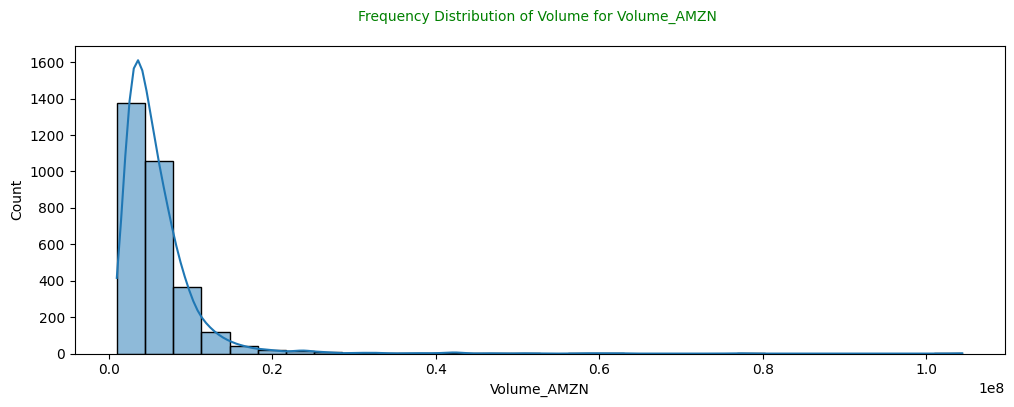

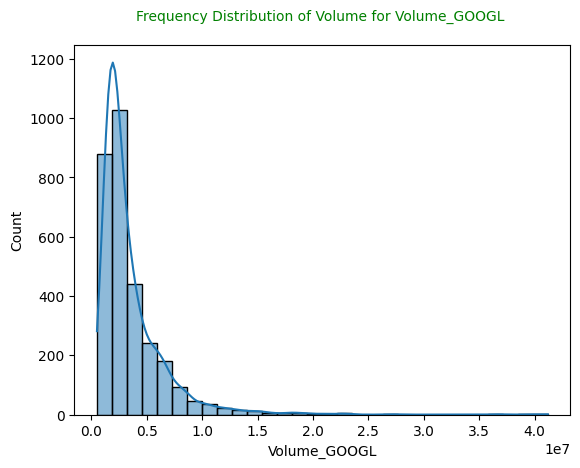

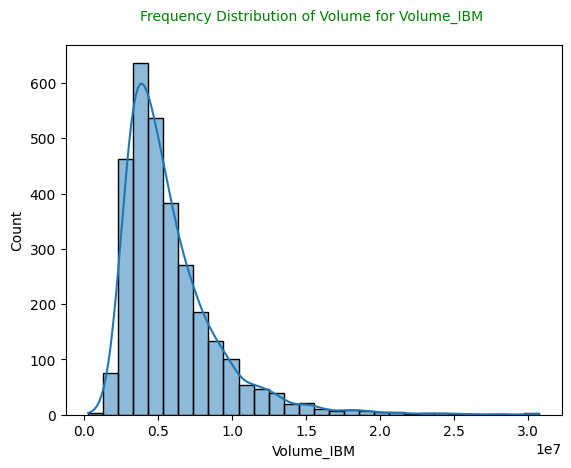

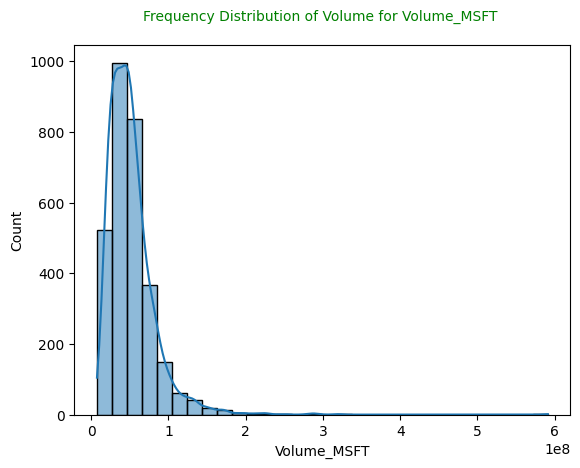

In [22]:
# Frequency distribution of volumes
Volume_cols = [col for col in Stock_Price_Joined_df.columns if 'Volume' in col]
plt.figure(figsize=(12, 4))
for col in Volume_cols:
    #Histplot
    sns.histplot(Stock_Price_Joined_df[col], bins=30, kde=True)
    plt.title(f"Frequency Distribution of Volume for {col} \n", fontdict={'fontsize': 10, 'fontweight' : 4, 'color' : 'Green'})
    plt.show()

In [23]:
# Showing Frequency distribution of all the companies comparing with each other
def frequency_distribution (Stock_Price_Joined_df, feature_cols, str) :
    display_cols = [col for col in feature_cols if str in col]
    plt.figure(figsize=(15, 45))

    for i, col in enumerate(display_cols, 1):
        #Histplot
        ax = plt.subplot(10, 2, i)
        sns.histplot(Stock_Price_Joined_df[col], bins=100, kde=True, ax = ax)
        plt.title(f"Frequency Distribution for {col} \n", fontdict={'fontsize': 10, 'fontweight' : 4, 'color' : 'Green'})
    plt.tight_layout()
    plt.show()



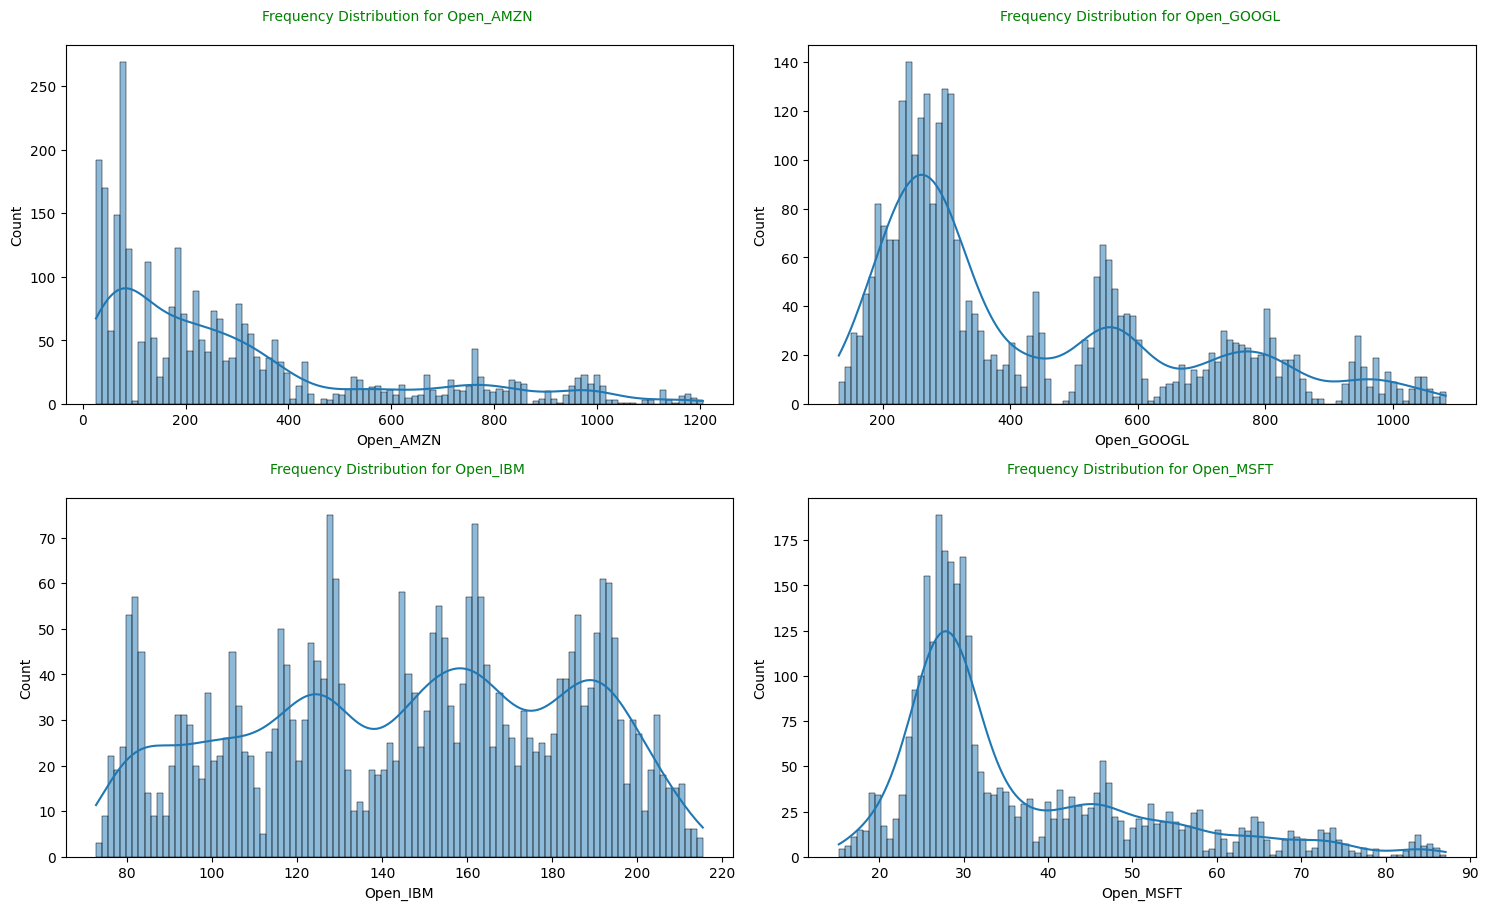

In [24]:
frequency_distribution (Stock_Price_Joined_df, feature_cols, 'Open')

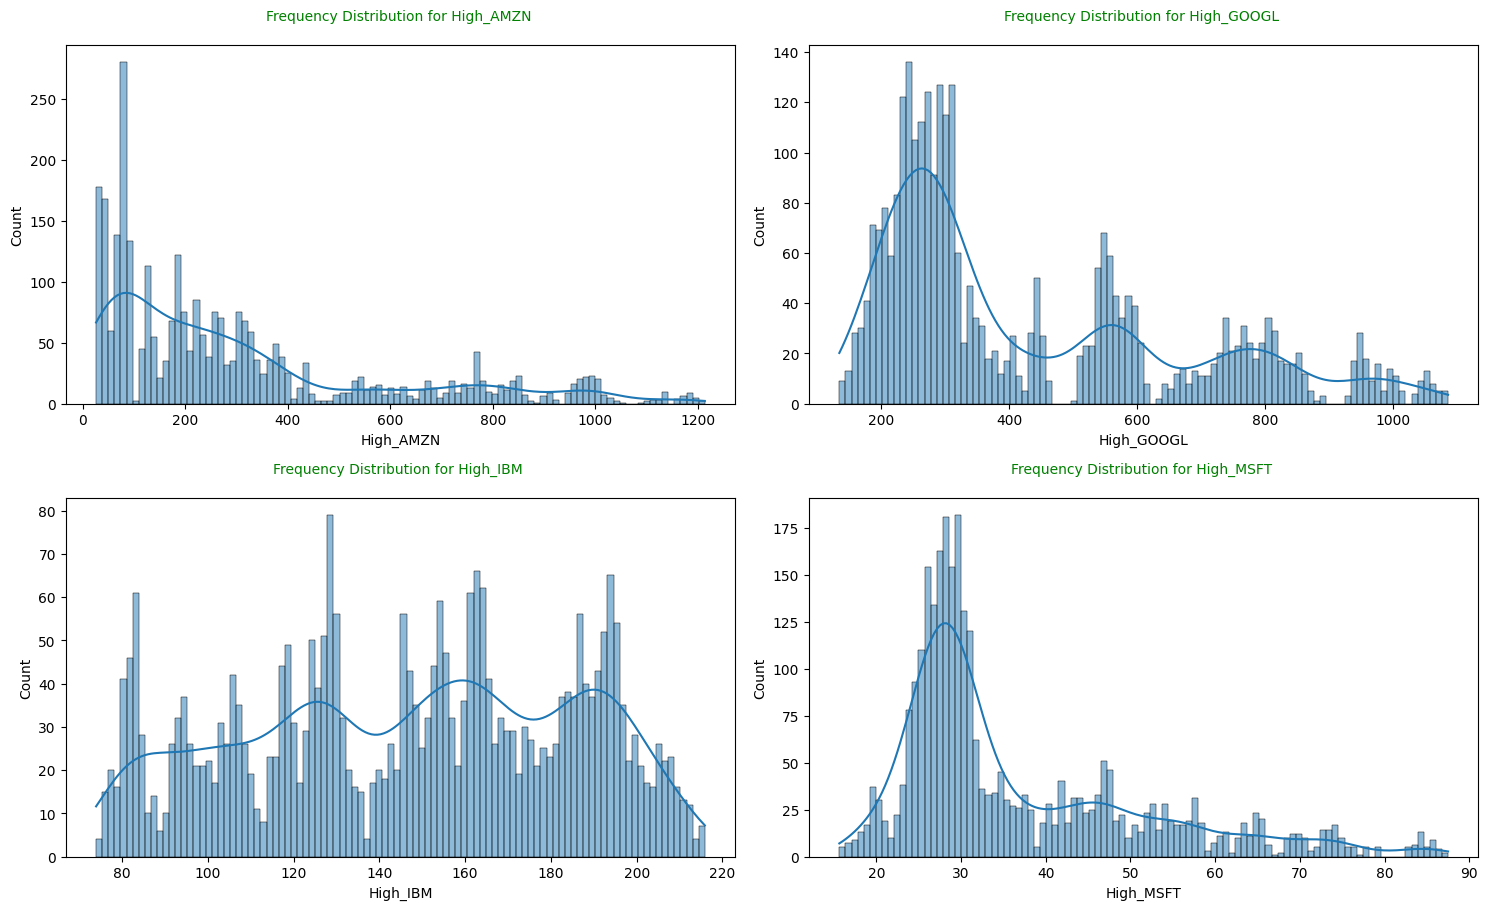

In [25]:
frequency_distribution (Stock_Price_Joined_df, feature_cols, 'High')

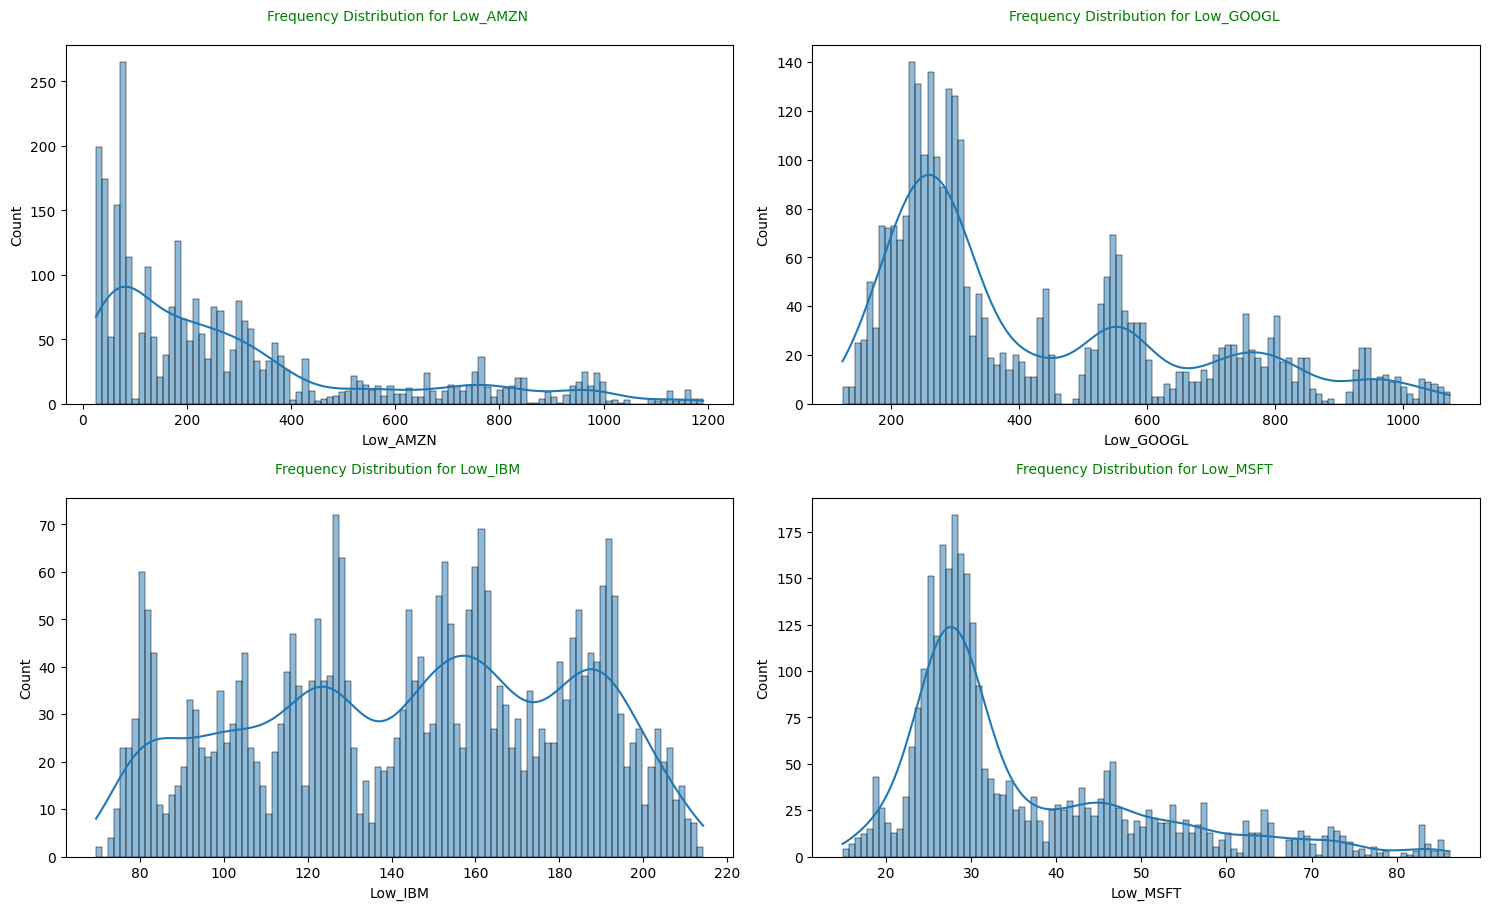

In [26]:
frequency_distribution (Stock_Price_Joined_df, feature_cols, 'Low')

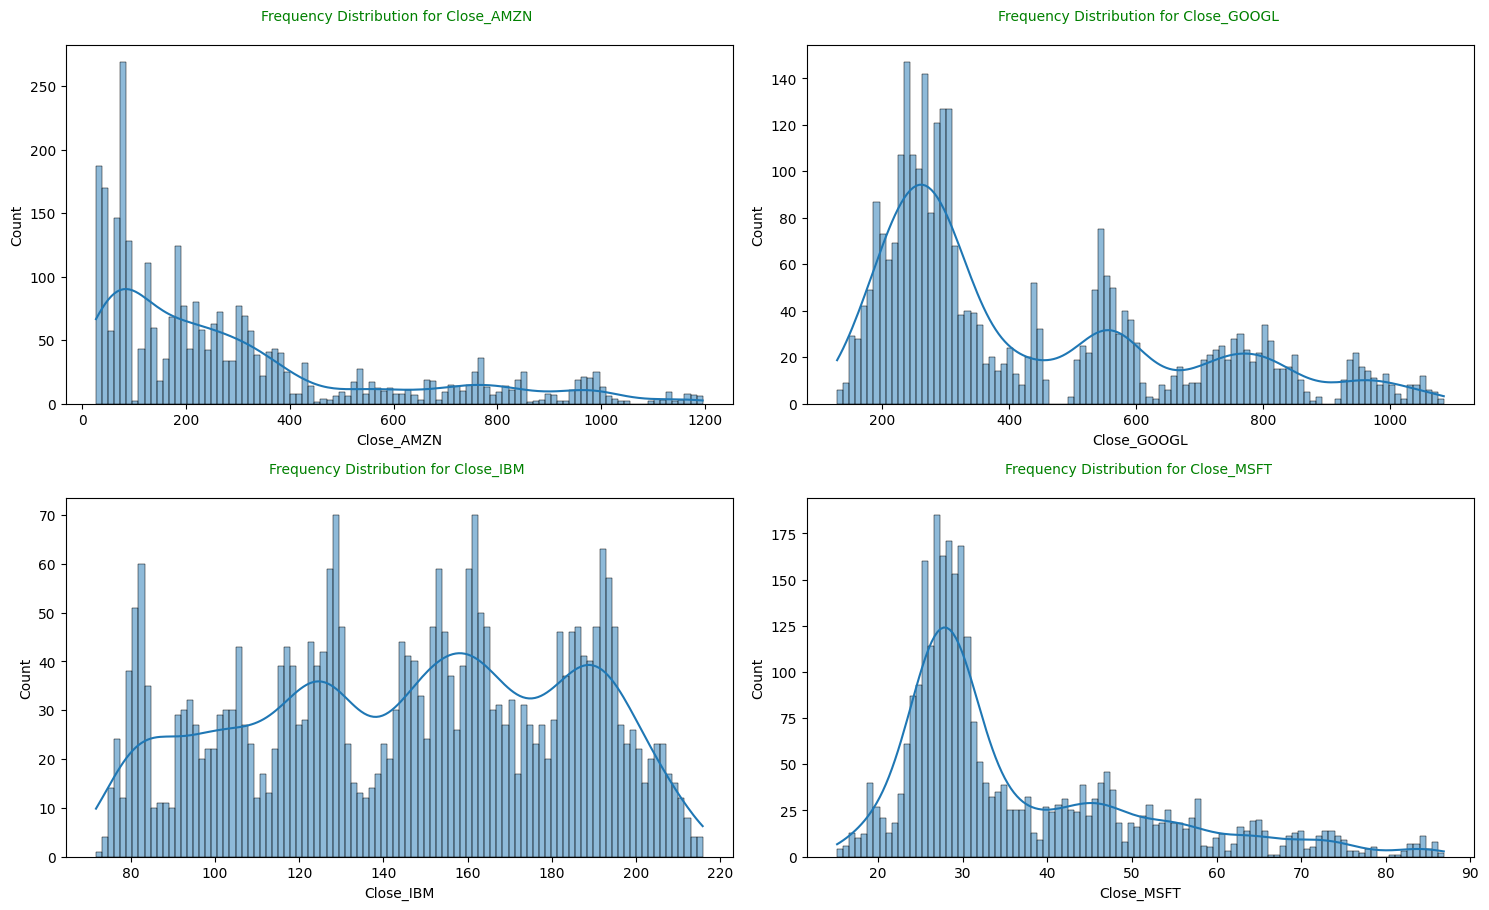

In [27]:
frequency_distribution (Stock_Price_Joined_df, feature_cols, 'Close')

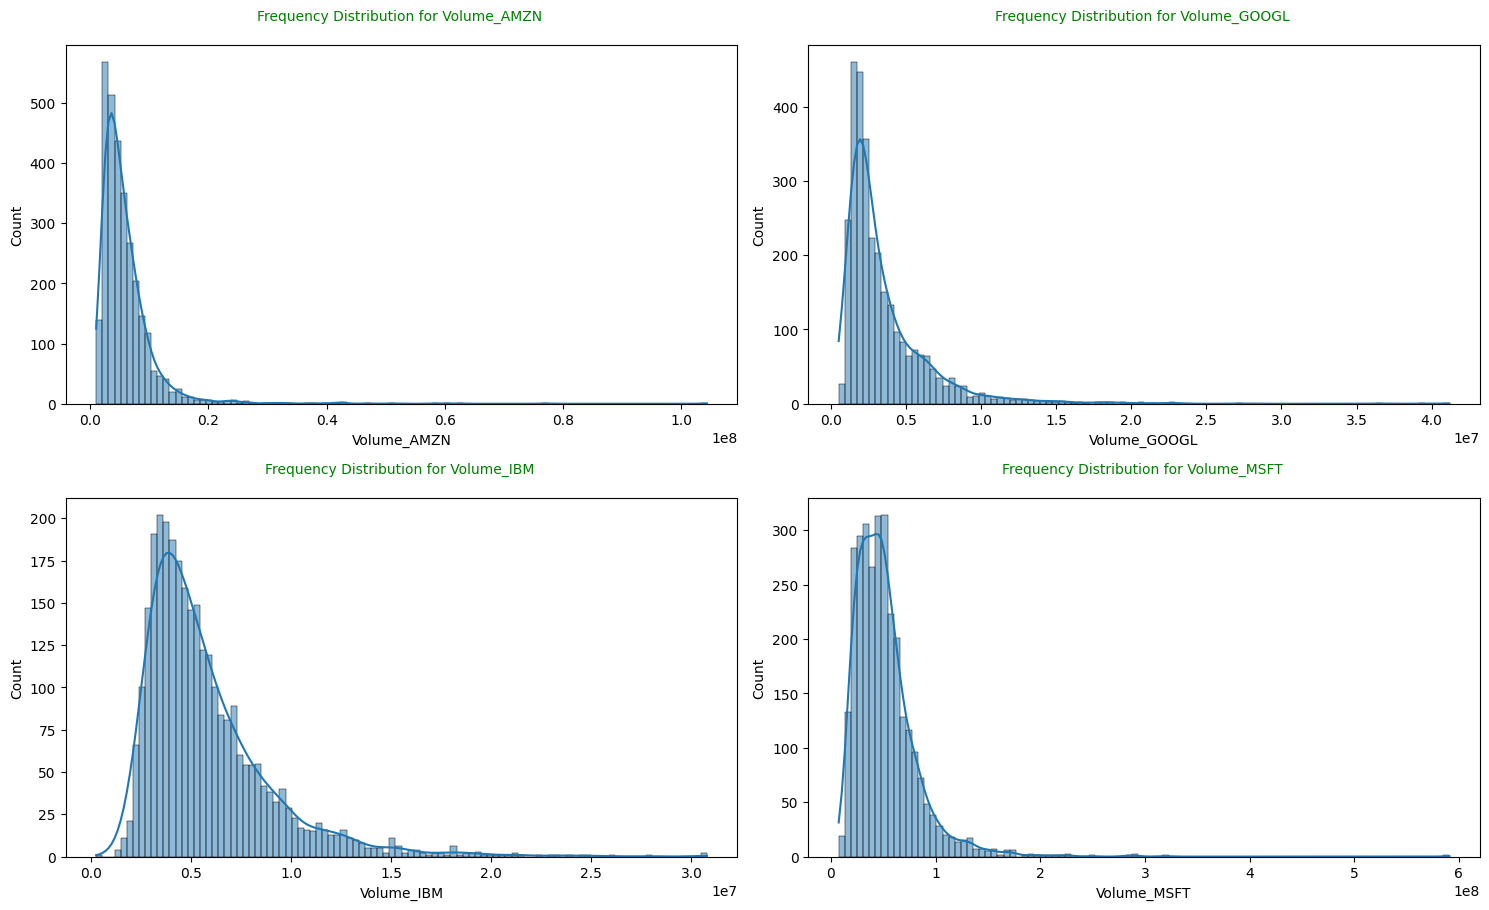

In [28]:
frequency_distribution (Stock_Price_Joined_df, feature_cols, 'Volume')

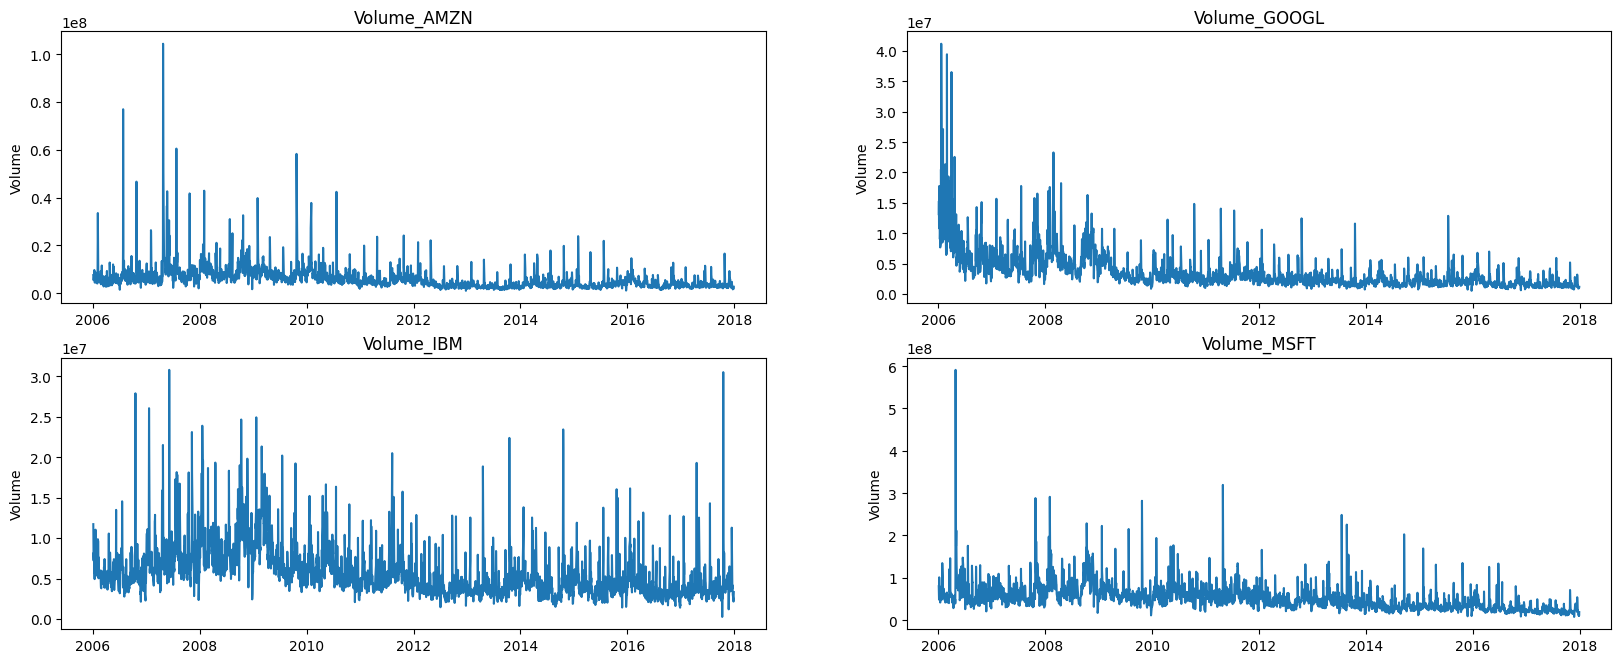

In [29]:
# Stock volume variation over time

plt.figure(figsize=(20, 12))
for index, col in enumerate(Volume_cols):
  plt.subplot(3, 2, index + 1)
  plt.plot(Stock_Price_Joined_df['Date'], Stock_Price_Joined_df[col])
  plt.title(Volume_cols[index])
  plt.ylabel('Volume')

In [30]:
# Showing Frequency distribution for Volume of all the companies over time comparing with each other

def time_variation (Stock_Price_Joined_df, feature_cols, str) :
    display_cols = [col for col in feature_cols if str in col]
    plt.figure(figsize=(15, 30))

    for i, col in enumerate(display_cols, 1):
        #Histplot
        ax = plt.subplot(10, 2, i)
        plt.plot(Stock_Price_Joined_df['Date'], Stock_Price_Joined_df[col])
        plt.title(f"Time Variation for {col} \n", fontdict={'fontsize': 10, 'fontweight' : 4, 'color' : 'Green'})
        plt.ylabel('Volume')
    plt.tight_layout()
    plt.show()

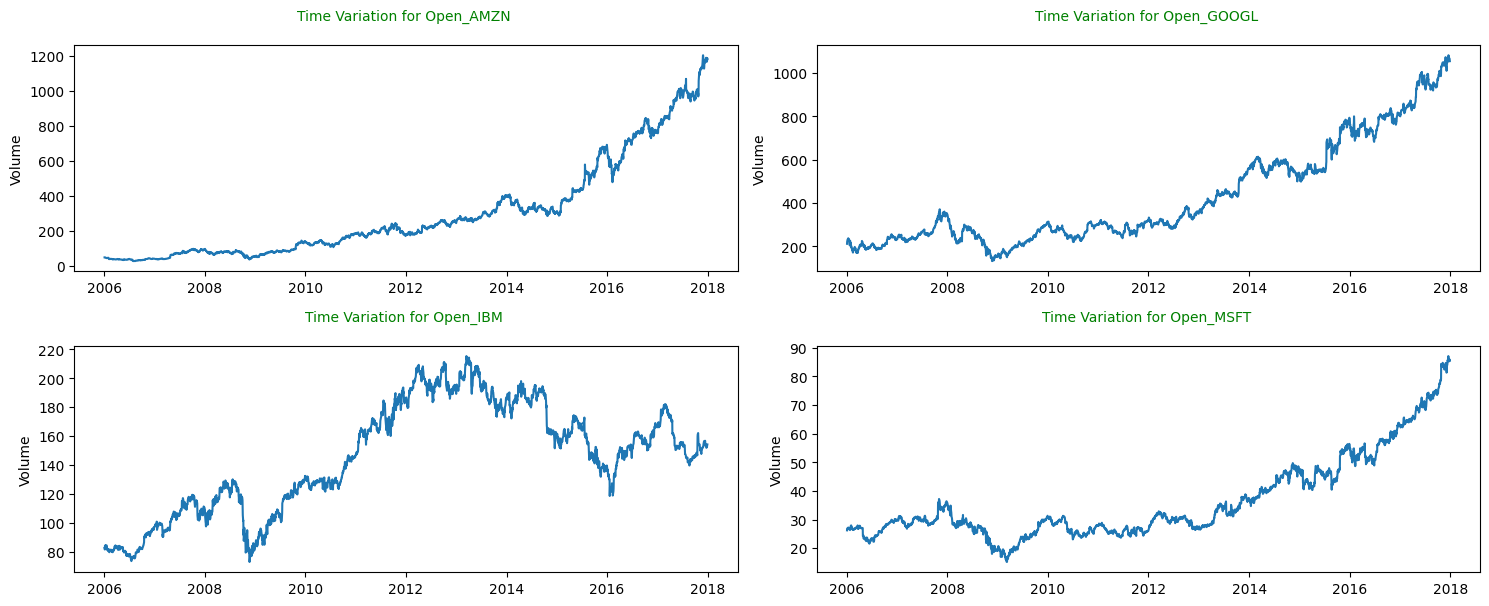

In [31]:
time_variation (Stock_Price_Joined_df, feature_cols, 'Open')

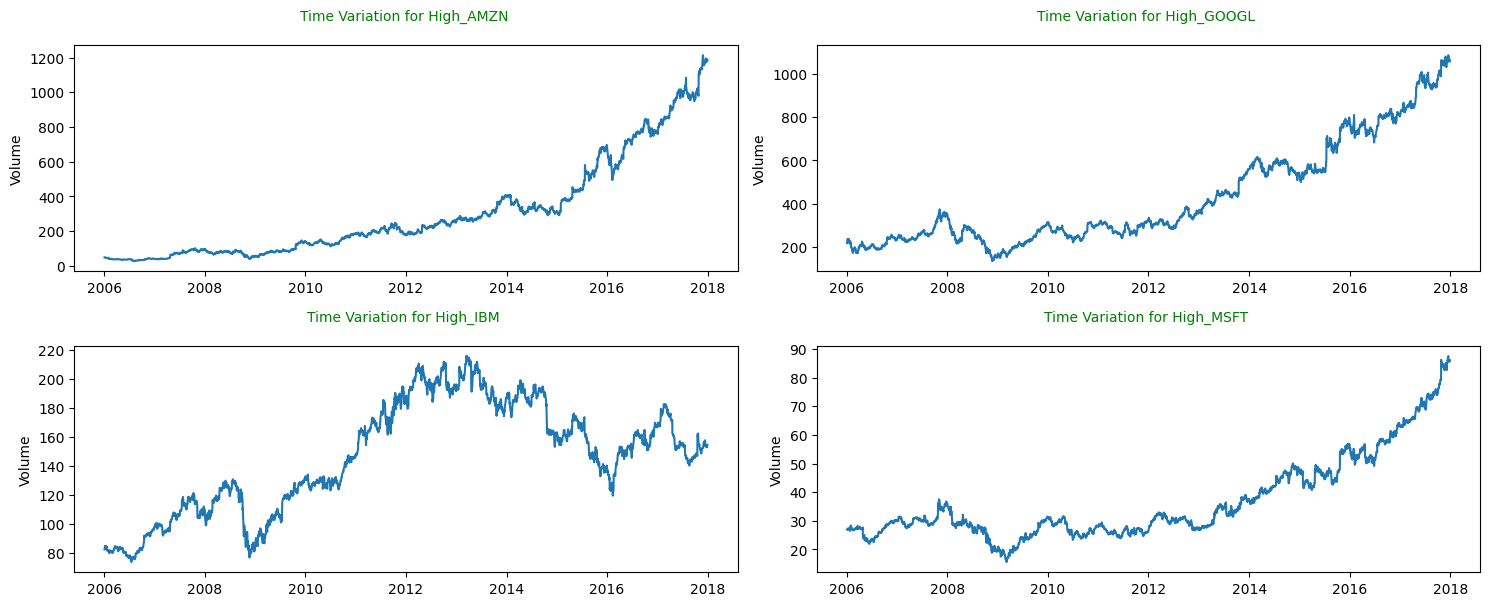

In [32]:
time_variation (Stock_Price_Joined_df, feature_cols, 'High')

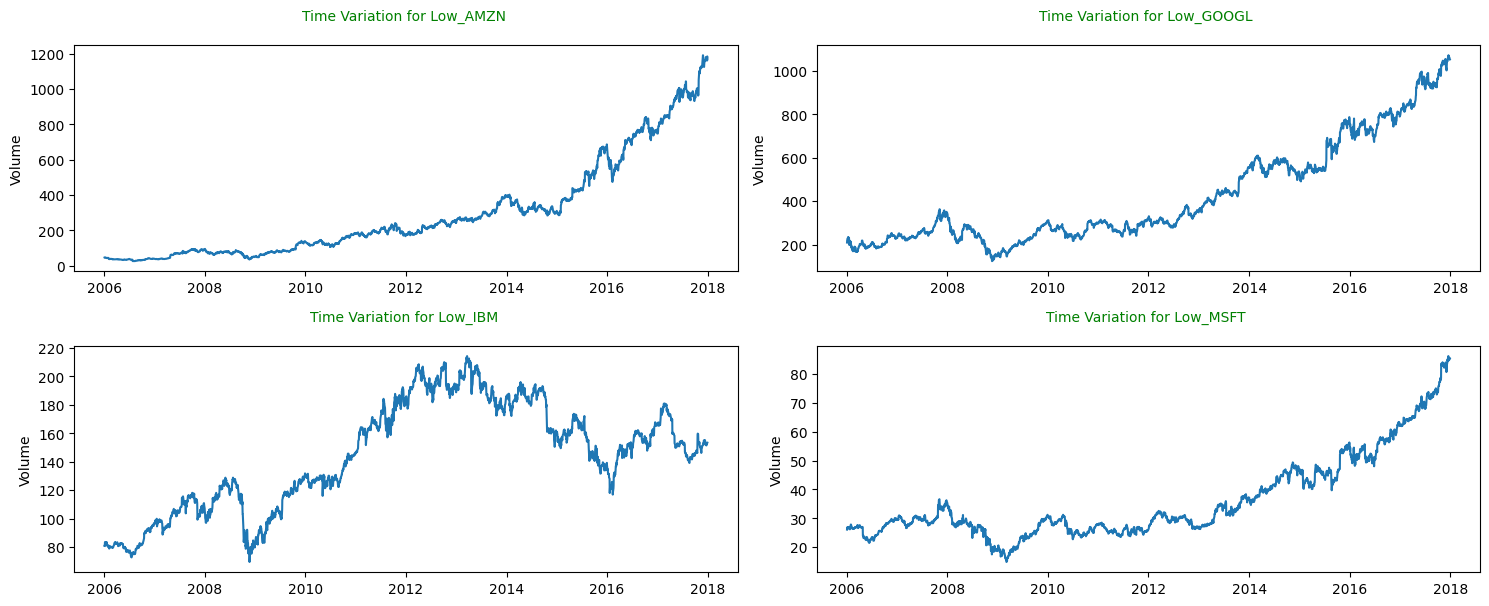

In [33]:
time_variation (Stock_Price_Joined_df, feature_cols, 'Low')

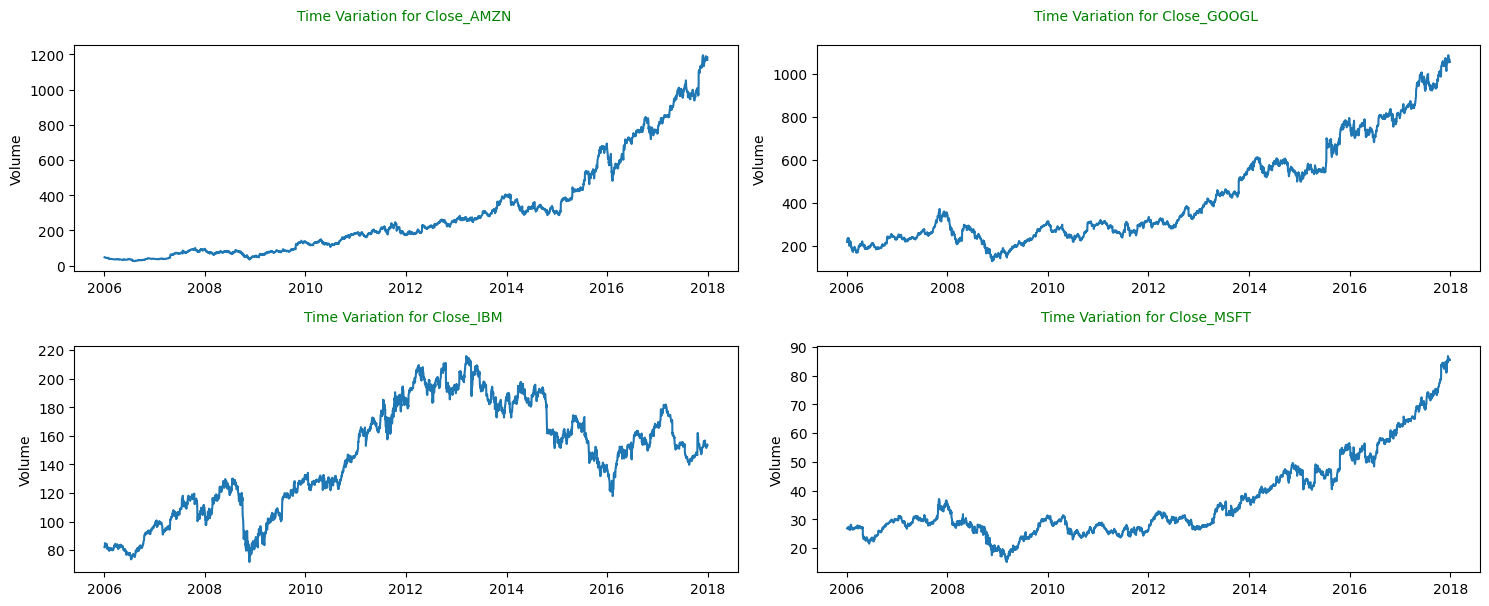

In [34]:
time_variation (Stock_Price_Joined_df, feature_cols, 'Close')

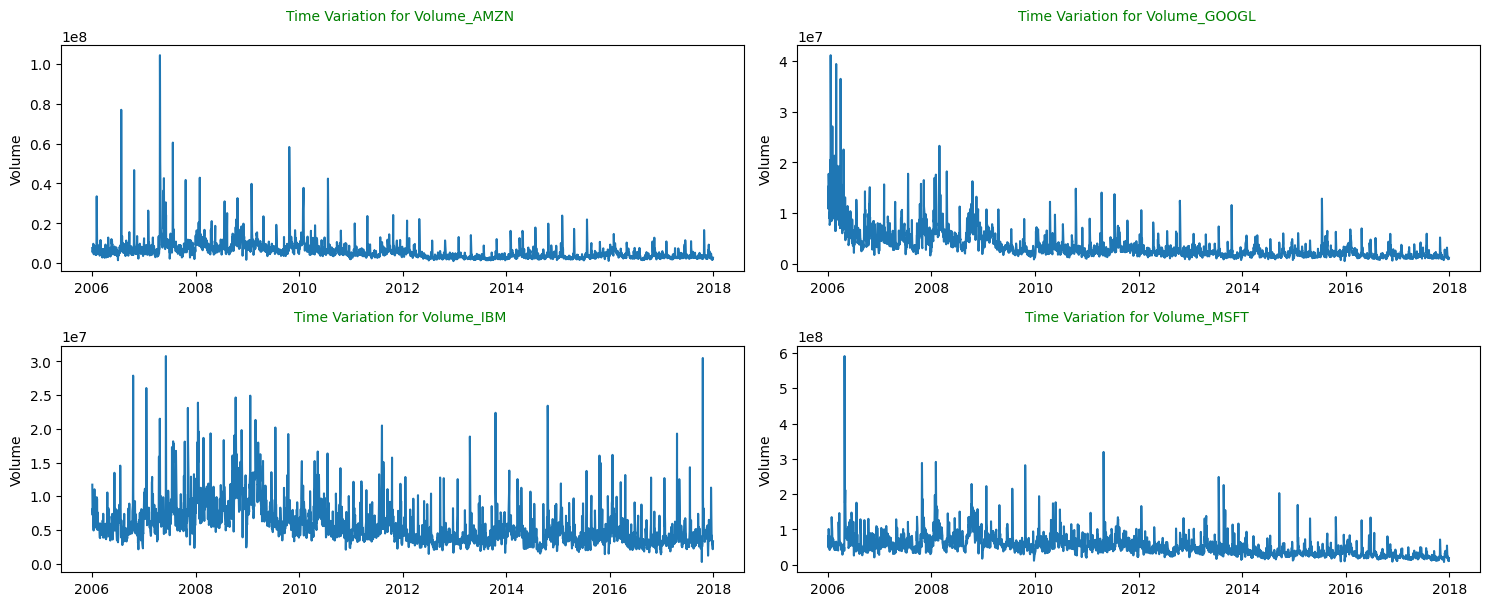

In [35]:
time_variation (Stock_Price_Joined_df, feature_cols, 'Volume')


#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

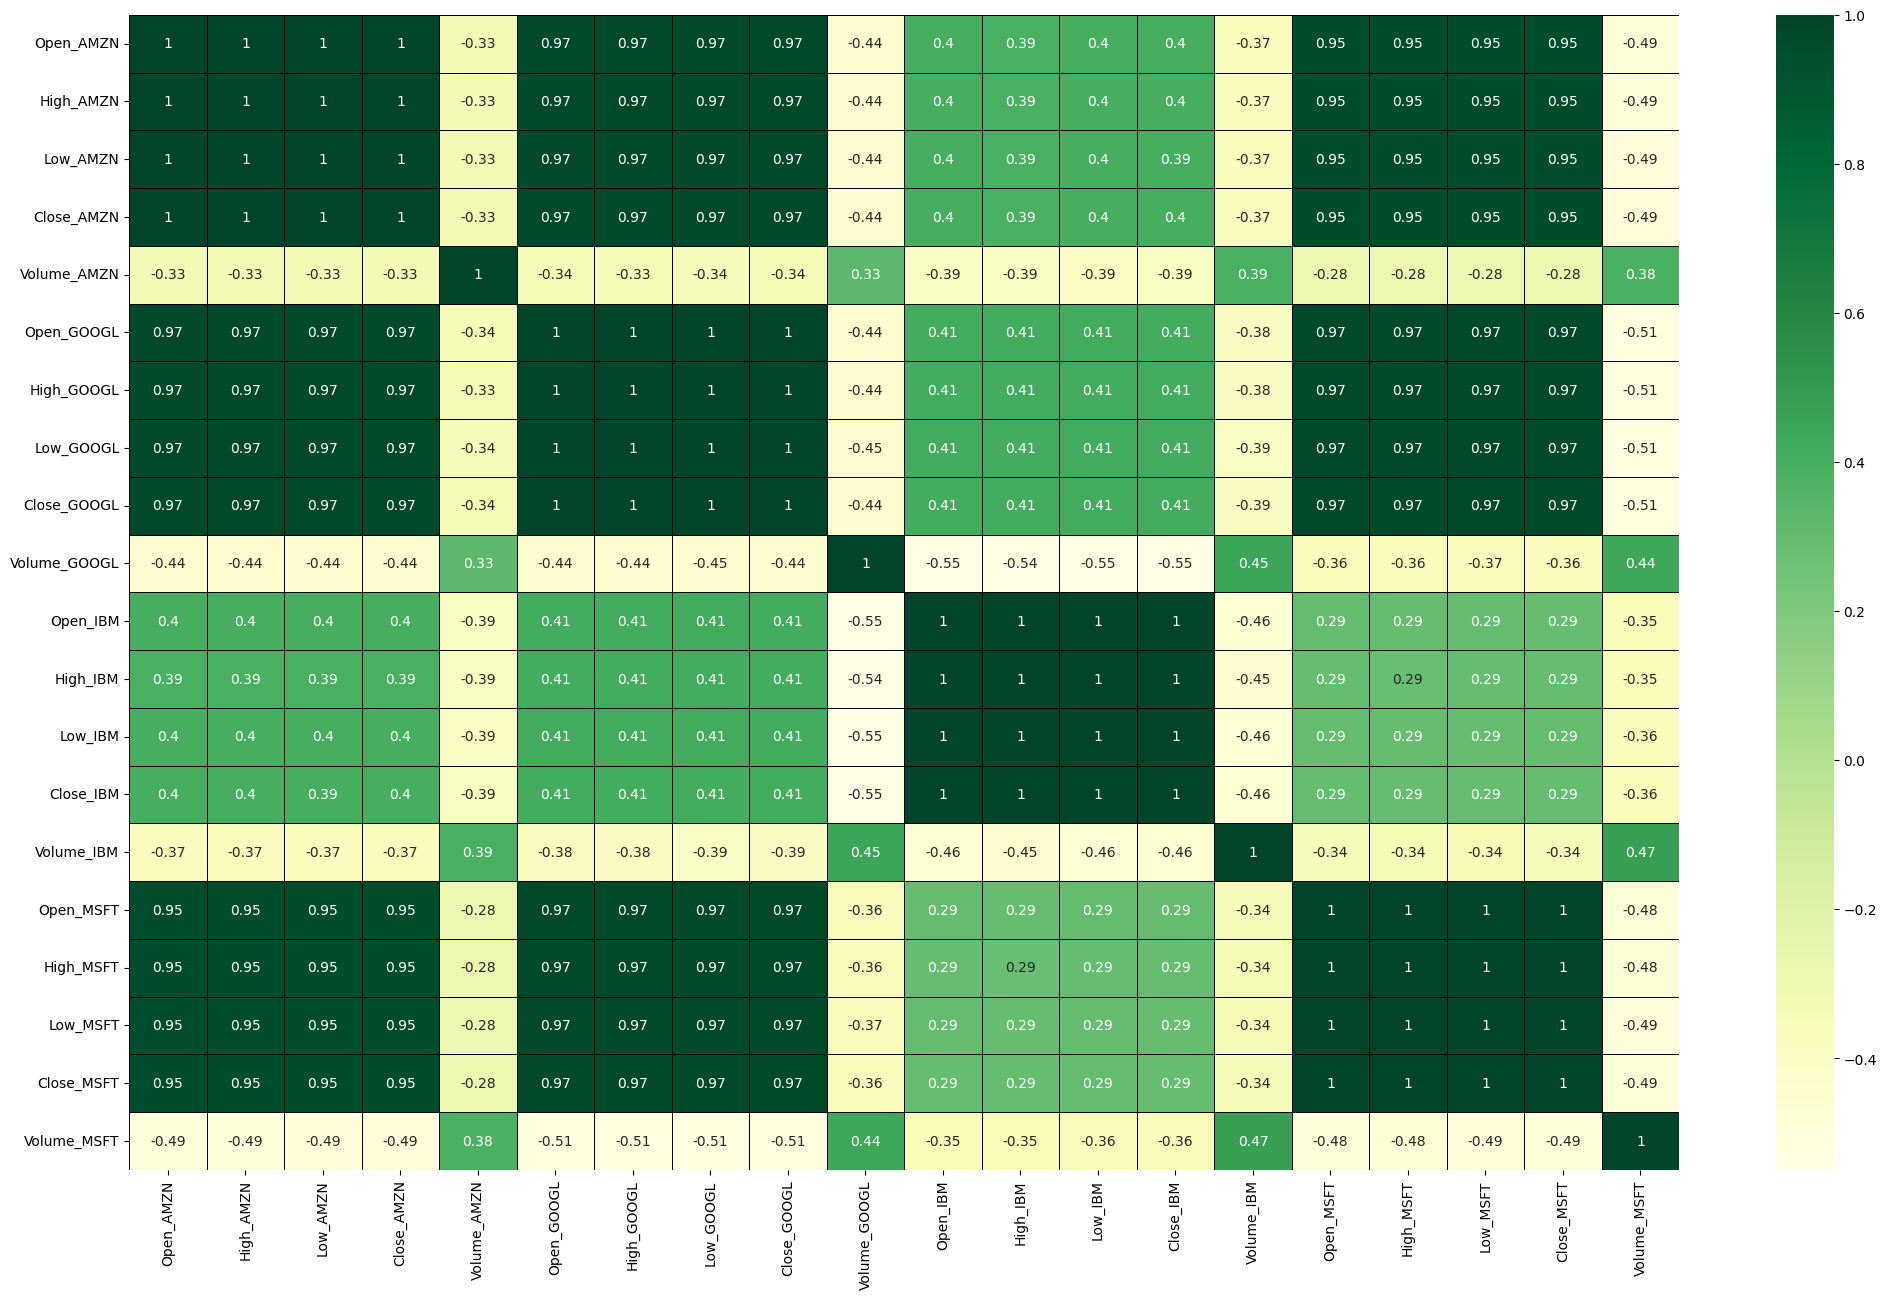

In [36]:
# Analyse correlations
# Checking correlation among all columns
plt.figure(figsize = (25,15))
sns.heatmap(Stock_Price_Joined_df.corr(numeric_only=True), cmap = "YlGn", linewidths=0.5, linecolor='black', annot=True)
plt.show()

In [37]:
# Checking the correlation between the Closing prices and Volume
corr_columns = []

for stock in ['AMZN', 'GOOGL', 'MSFT', 'IBM']:
  for col in ['Open', 'High', 'Low']:
    corr_columns.append(f"{col}_{stock}")
Closing_Stocks_df = Stock_Price_Joined_df.drop(corr_columns, axis=1)
Closing_Stocks_df.head()

Date  Close_AMZN  Volume_AMZN  Close_GOOGL  Volume_GOOGL  Close_IBM  \
0 2006-01-03       47.58      7582127       217.83      13137450      82.06   
1 2006-01-04       47.25      7440914       222.84      15292353      81.95   
2 2006-01-05       47.65      5417258       225.85      10815661      82.50   
3 2006-01-06       47.87      6154285       233.06      17759521      84.95   
4 2006-01-09       47.08      8945056       233.68      12795837      83.73   

   Volume_IBM  Close_MSFT  Volume_MSFT  
0    11715200       26.84     79974418  
1     9840600       26.97     57975661  
2     7213500       26.99     48247610  
3     8197400       26.91    100969092  
4     6858200       26.86     55627836

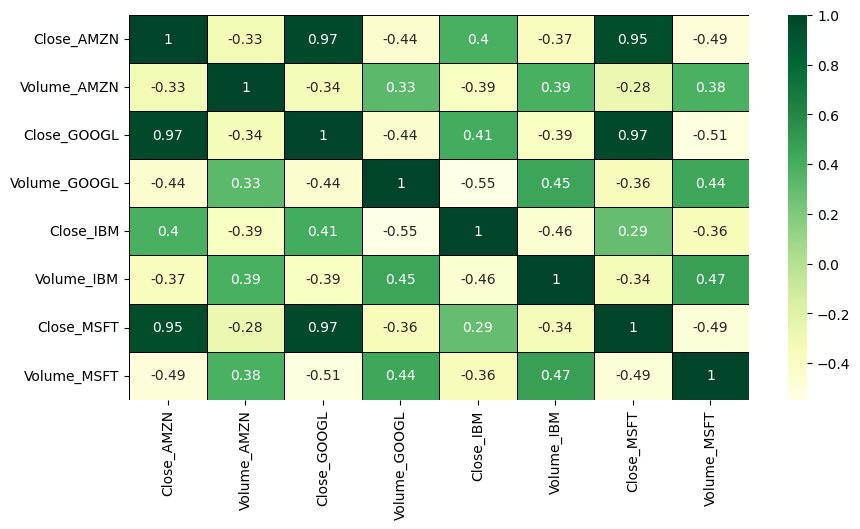

In [38]:
plt.figure(figsize = (10,5))
sns.heatmap(Closing_Stocks_df.corr(numeric_only=True), cmap = "YlGn", linewidths=0.5, linecolor='black', annot=True)
plt.show()

In [39]:
# Showing all column names for further evaluations
Stock_Price_Joined_df.columns

Index(['Date', 'Open_AMZN', 'High_AMZN', 'Low_AMZN', 'Close_AMZN',
       'Volume_AMZN', 'Open_GOOGL', 'High_GOOGL', 'Low_GOOGL', 'Close_GOOGL',
       'Volume_GOOGL', 'Open_IBM', 'High_IBM', 'Low_IBM', 'Close_IBM',
       'Volume_IBM', 'Open_MSFT', 'High_MSFT', 'Low_MSFT', 'Close_MSFT',
       'Volume_MSFT'],
      dtype='object')

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [40]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_windowed_data(Stock_Price_Joined_df, window_size, step_size, target_col):

    X_windows = []
    y_values = []

    # Sorting the data to Ensure its sorted by time
    Stock_Price_Joined_df = Stock_Price_Joined_df.sort_values(by='Date').reset_index(drop=True)

    for begin in range(0, len(Stock_Price_Joined_df) - window_size, step_size):
        end = begin + window_size

        window = Stock_Price_Joined_df.iloc[begin:end]
        target = Stock_Price_Joined_df[target_col].iloc[end]

        X_windows.append(window.drop(columns=['Date']).values)  # exclude 'Date' from input features
        y_values.append(target)

    return X_windows, y_values

In [41]:
# Sample code to test the new function create_windowed_data and to view the Windowed data
window_size = 3
step_size = 2
target_col = ['Close_AMZN']  # ['Close_GOOGL','Close_IBM', 'Close_MSFT']

X, y = create_windowed_data(Stock_Price_Joined_df, window_size, step_size, target_col)

print(f"X : {len(X)}, y : {len(y)}")

X : 1508, y : 1508


In [42]:
print(X[1])

[[4.71600000e+01 4.82000000e+01 4.71100000e+01 4.76500000e+01
  5.41725800e+06 2.23220000e+02 2.26000000e+02 2.20970000e+02
  2.25850000e+02 1.08156610e+07 8.14000000e+01 8.29000000e+01
  8.10000000e+01 8.25000000e+01 7.21350000e+06 2.69600000e+01
  2.71300000e+01 2.69100000e+01 2.69900000e+01 4.82476100e+07]
 [4.79700000e+01 4.85800000e+01 4.73200000e+01 4.78700000e+01
  6.15428500e+06 2.28660000e+02 2.35490000e+02 2.26850000e+02
  2.33060000e+02 1.77595210e+07 8.39500000e+01 8.50300000e+01
  8.34100000e+01 8.49500000e+01 8.19740000e+06 2.68900000e+01
  2.70000000e+01 2.64900000e+01 2.69100000e+01 1.00969092e+08]
 [4.65500000e+01 4.71000000e+01 4.64000000e+01 4.70800000e+01
  8.94505600e+06 2.33440000e+02 2.36940000e+02 2.30700000e+02
  2.33680000e+02 1.27958370e+07 8.41000000e+01 8.42500000e+01
  8.33800000e+01 8.37300000e+01 6.85820000e+06 2.69300000e+01
  2.70700000e+01 2.67600000e+01 2.68600000e+01 5.56278360e+07]]


In [43]:
print(y[0])

Close_AMZN    47.87
Name: 3, dtype: float64


In [44]:
len(X)

1508

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [45]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windowed_data(X_windows, y_values):
     # Create scalers
    X_scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaler = MinMaxScaler(feature_range=(0, 1))

    # Reshape data for scaling
    X_windows = np.array(X_windows)
    X_combined = np.vstack([window for window in X_windows])
    X_scaler.partial_fit(X_combined)

    # Scale X windows
    X_scaled = [X_scaler.transform(window) for window in X_windows]
    X_scaled = np.array(X_scaled)

    # Convert y_values to numpy array
    y_combined = np.vstack([y.values.reshape(1, -1) if isinstance(y, pd.Series)
                           else np.array([[y]]) if np.isscalar(y)
                           else np.array(y).reshape(1, -1)
                           for y in y_values])
    y_scaler.partial_fit(y_combined)

    # Scale y values
    y_scaled = y_scaler.transform(y_combined)
    y_scaled = np.array(y_scaled)

    return X_scaled, y_scaled, X_scaler, y_scaler

In [46]:
# Sample code to test the new function scale_windowed_data and to view the Scaled data
X_scaled, y_scaled, X_scaler, y_scaler  = scale_windowed_data(X, y)

print("X_scaled shape:", X_scaled.shape)
print("y_scaled shape:", y_scaled.shape)

X_scaled shape: (1508, 3, 20)
y_scaled shape: (1508, 1)


In [47]:
X_scaled

array([[[0.01813724, 0.01815333, 0.0175821 , ..., 0.15737108,
         0.16304045, 0.12430128],
        [0.01814573, 0.01805224, 0.01795965, ..., 0.16676009,
         0.16485356, 0.08660978],
        [0.01787426, 0.01844816, 0.01832005, ..., 0.16872197,
         0.1651325 , 0.06994226]],

       [[0.01787426, 0.01844816, 0.01832005, ..., 0.16872197,
         0.1651325 , 0.06994226],
        [0.01856141, 0.01876827, 0.01850024, ..., 0.16283632,
         0.16401674, 0.16027244],
        [0.01735678, 0.01752154, 0.01771081, ..., 0.16661996,
         0.16331939, 0.08258714]],

       [[0.01735678, 0.01752154, 0.01771081, ..., 0.16661996,
         0.16331939, 0.08258714],
        [0.01723802, 0.01722671, 0.0168184 , ..., 0.16423767,
         0.16527197, 0.09851632],
        [0.01659329, 0.01634221, 0.01587451, ..., 0.16858184,
         0.1693166 , 0.10742332]],

       ...,

       [[0.98665581, 0.98278171, 0.98969444, ..., 0.98654709,
         0.98577406, 0.02758349],
        [0.98780105, 

In [48]:
y_scaled

array([[0.0186719 ],
       [0.01677045],
       [0.01566555],
       ...,
       [0.97838171],
       [0.99028719],
       [0.97933244]])

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [49]:
# Define a function to create input and output data points from the master DataFrame
def prepare_data_main(Stock_Price_Joined_df, target_col, window_size, step_size, train_split_ratio):
    # Create windows
    X, y = create_windowed_data(Stock_Price_Joined_df, window_size, step_size, target_col)

    # Scale data
    X_scaled, y_scaled, X_scaler, y_scaler = scale_windowed_data(X, y)

    # Step 3: Train-test split
    split_index = int(len(X_scaled) * train_split_ratio)

    X_train = X_scaled[:split_index]
    y_train = y_scaled[:split_index]
    X_test = X_scaled[split_index:]
    y_test = y_scaled[split_index:]

    return X_train, y_train, X_test, y_test, X_scaler, y_scaler

In [50]:
# Sample code to test the new function prepare_data_main and to view the Train Test shape for better understanding
df=Stock_Price_Joined_df
target_cols=['Close_AMZN']
window_size=90
step_size=1
train_split_ratio=0.7

X_train, y_train, X_test, y_test, X_scaler, y_scaler = prepare_data_main(
    df, target_cols, window_size, step_size, train_split_ratio
)

print(f"Train X: {X_train.shape}, Train y: {y_train.shape}")
print(f"Test X: {X_test.shape}, Test y: {y_test.shape}")

Train X: (2049, 90, 20), Train y: (2049, 1)
Test X: (879, 90, 20), Test y: (879, 1)


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

In [51]:
# Checking for patterns in different sequence lengths

def determine_sequence_lengths(Stock_Price_Joined_df, target_col, stock_name='AMZN'):
    plt.figure(figsize=(20, 18))

    # Full timeline as received in the main data
    plt.subplot(5, 1, 1)
    Stock_Price_Joined_df[target_col].plot()
    plt.title(f"{stock_name} Closing Price - Full Timeline")

    # Business Day average
    plt.subplot(5, 1, 2)
    Stock_Price_Joined_df[target_col].resample('B').mean().plot()
    plt.title(f"{stock_name} Business Day Average Closing Price")

    # Weekly average (which comprise of 5 working days)
    plt.subplot(5, 1, 3)
    Stock_Price_Joined_df[target_col].resample('5B').mean().plot()
    plt.title(f"{stock_name} Weekly Average Closing Price")

    # Monthly average - 22 Business days aprrox
    plt.subplot(5, 1, 4)
    Stock_Price_Joined_df[target_col].resample('22B').mean().plot()
    plt.title(f"{stock_name} Monthly Average Closing Price")

    # Business Quarter average - 63 Business days approx
    plt.subplot(5, 1, 5)
    Stock_Price_Joined_df[target_col].resample('63B').mean().plot()
    plt.title(f"{stock_name} Business Quarter Average Closing Price")

    plt.tight_layout()
    plt.show()

In [52]:
# Setting Date as Index for plotting
sp_df = Stock_Price_Joined_df.set_index('Date')

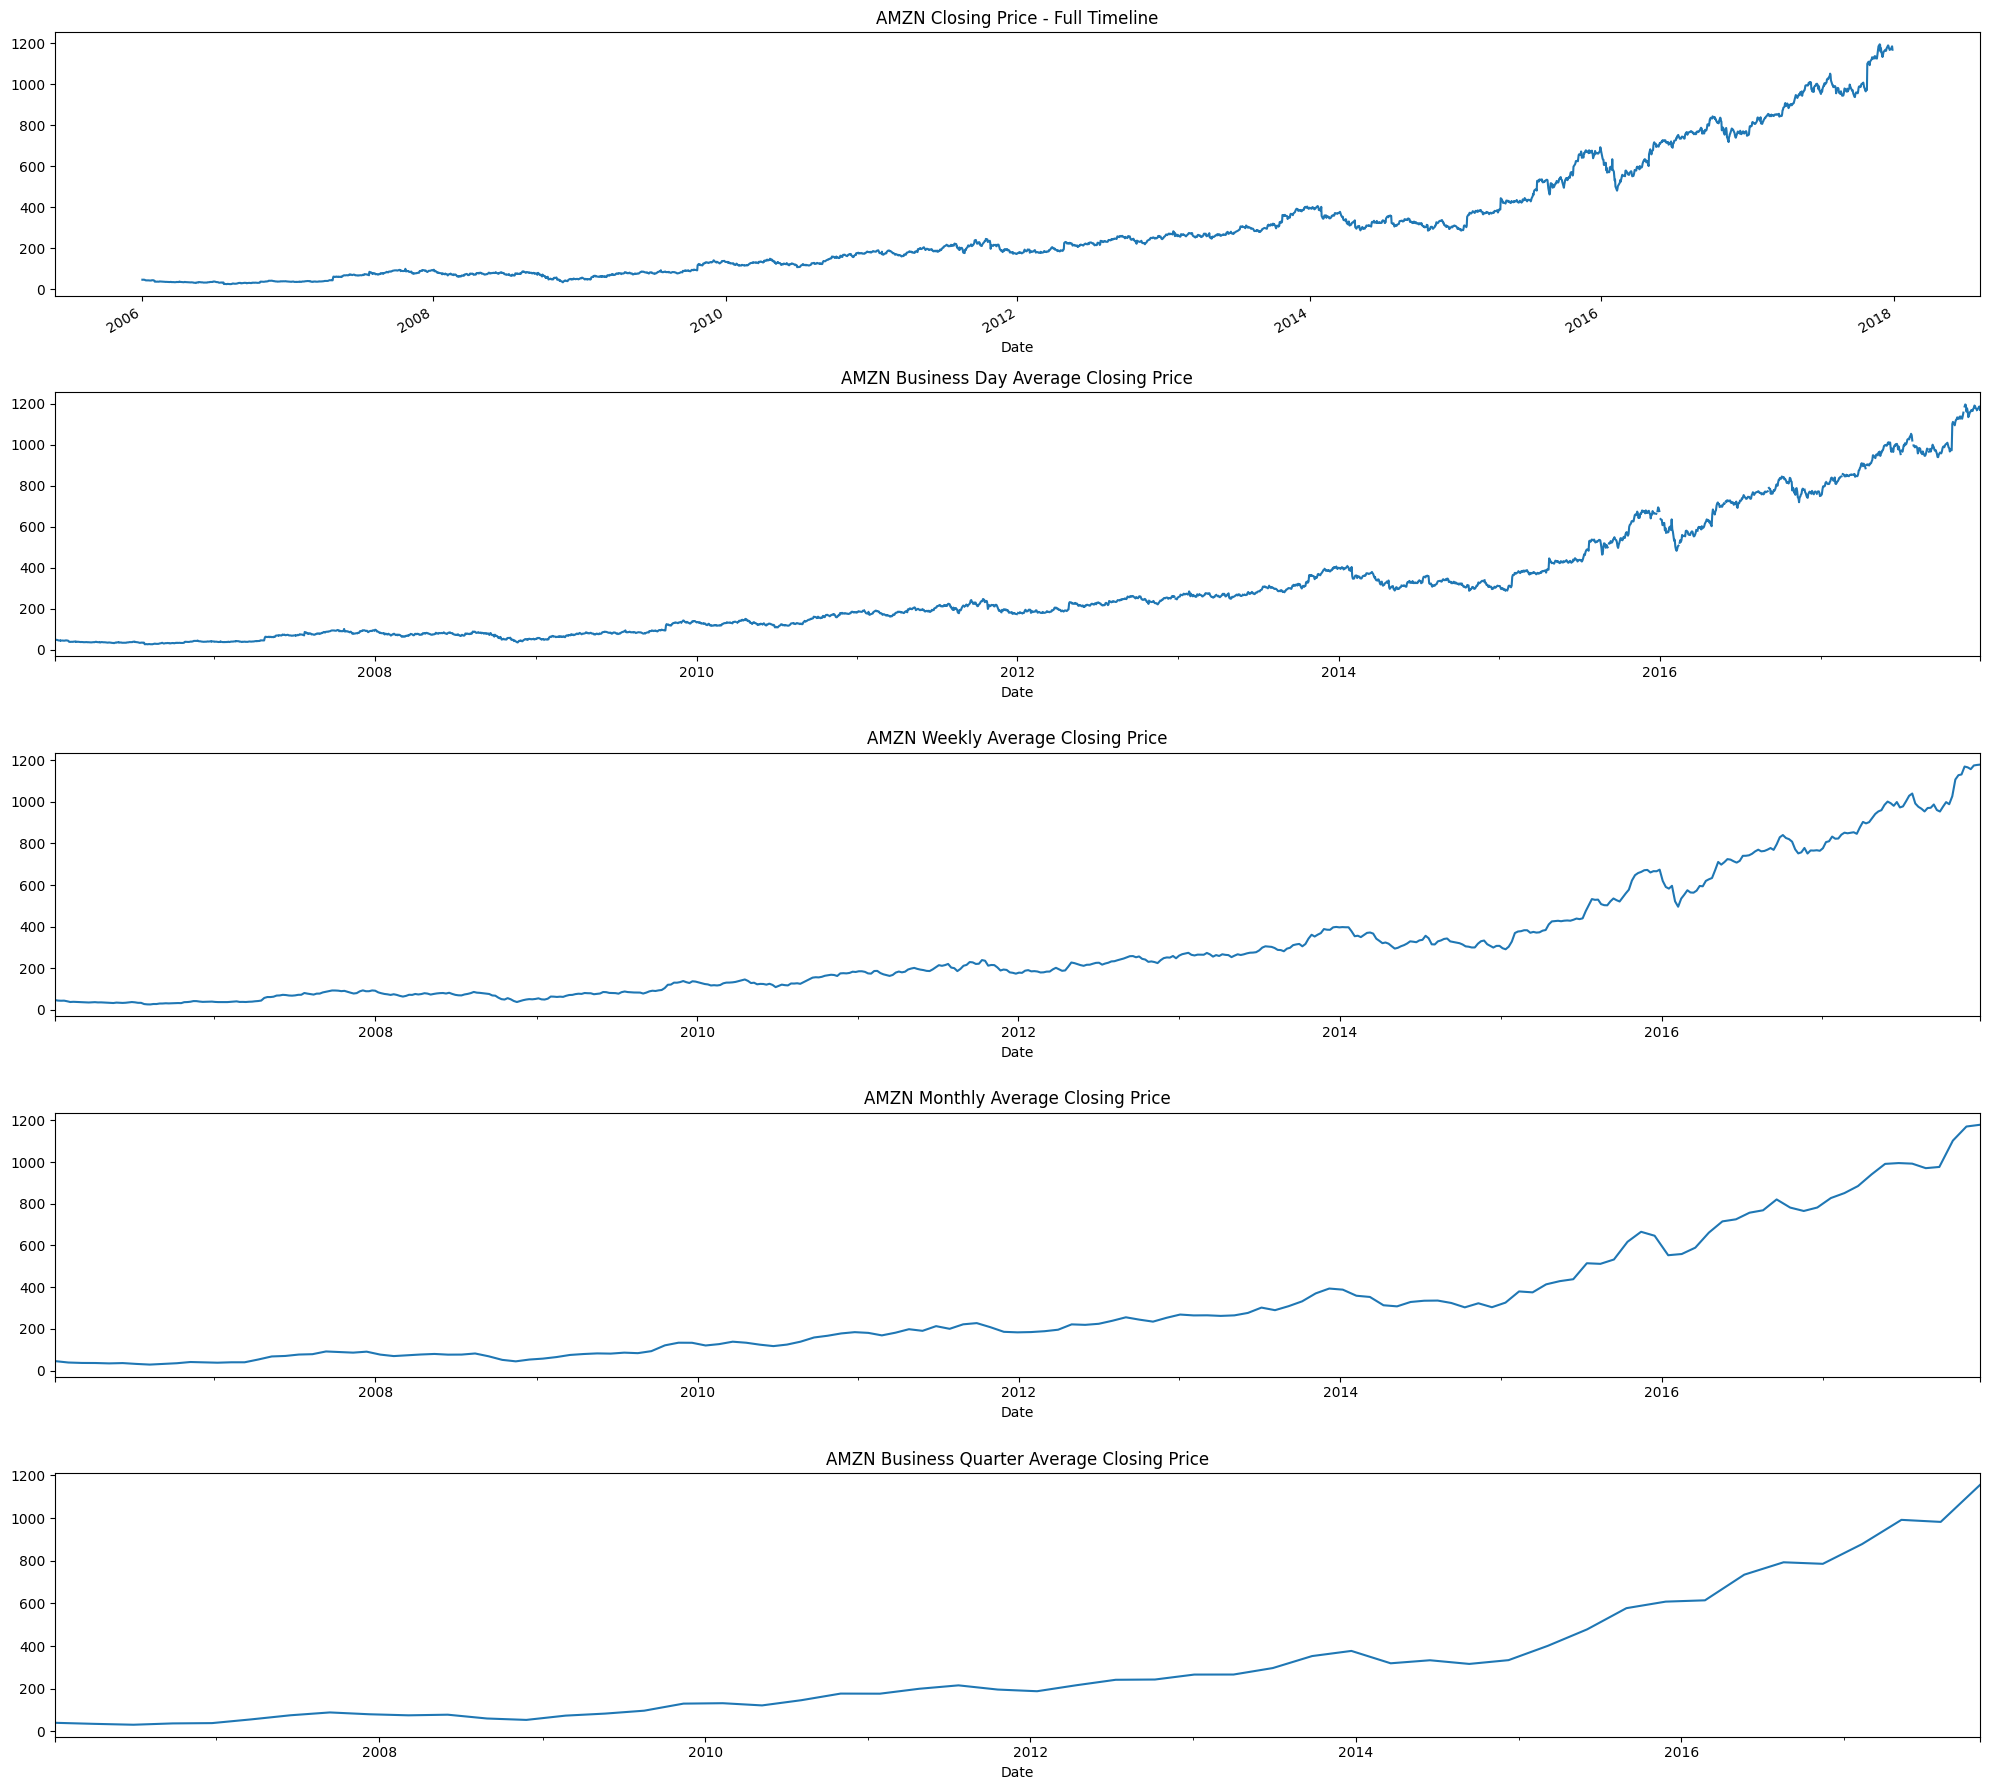

In [53]:
# Plotting the graph to see how target variable is varying with time
determine_sequence_lengths(sp_df, target_col='Close_AMZN', stock_name='AMZN')

##### -- Now plotting for all companies closing prices comparing with each other to understand the Trend

In [54]:
close_cols = [col for col in feature_cols if 'Close' in col]
companies = [col.replace('_Close', '') for col in close_cols]

# Weekly pattern (5 business days in a week)
weekly_window = 5

# Monthly pattern (roughly 23 business days in a month)
monthly_window = 23

# Quarterly pattern (roughly 65 business days in a quarter)
quarterly_window = 65

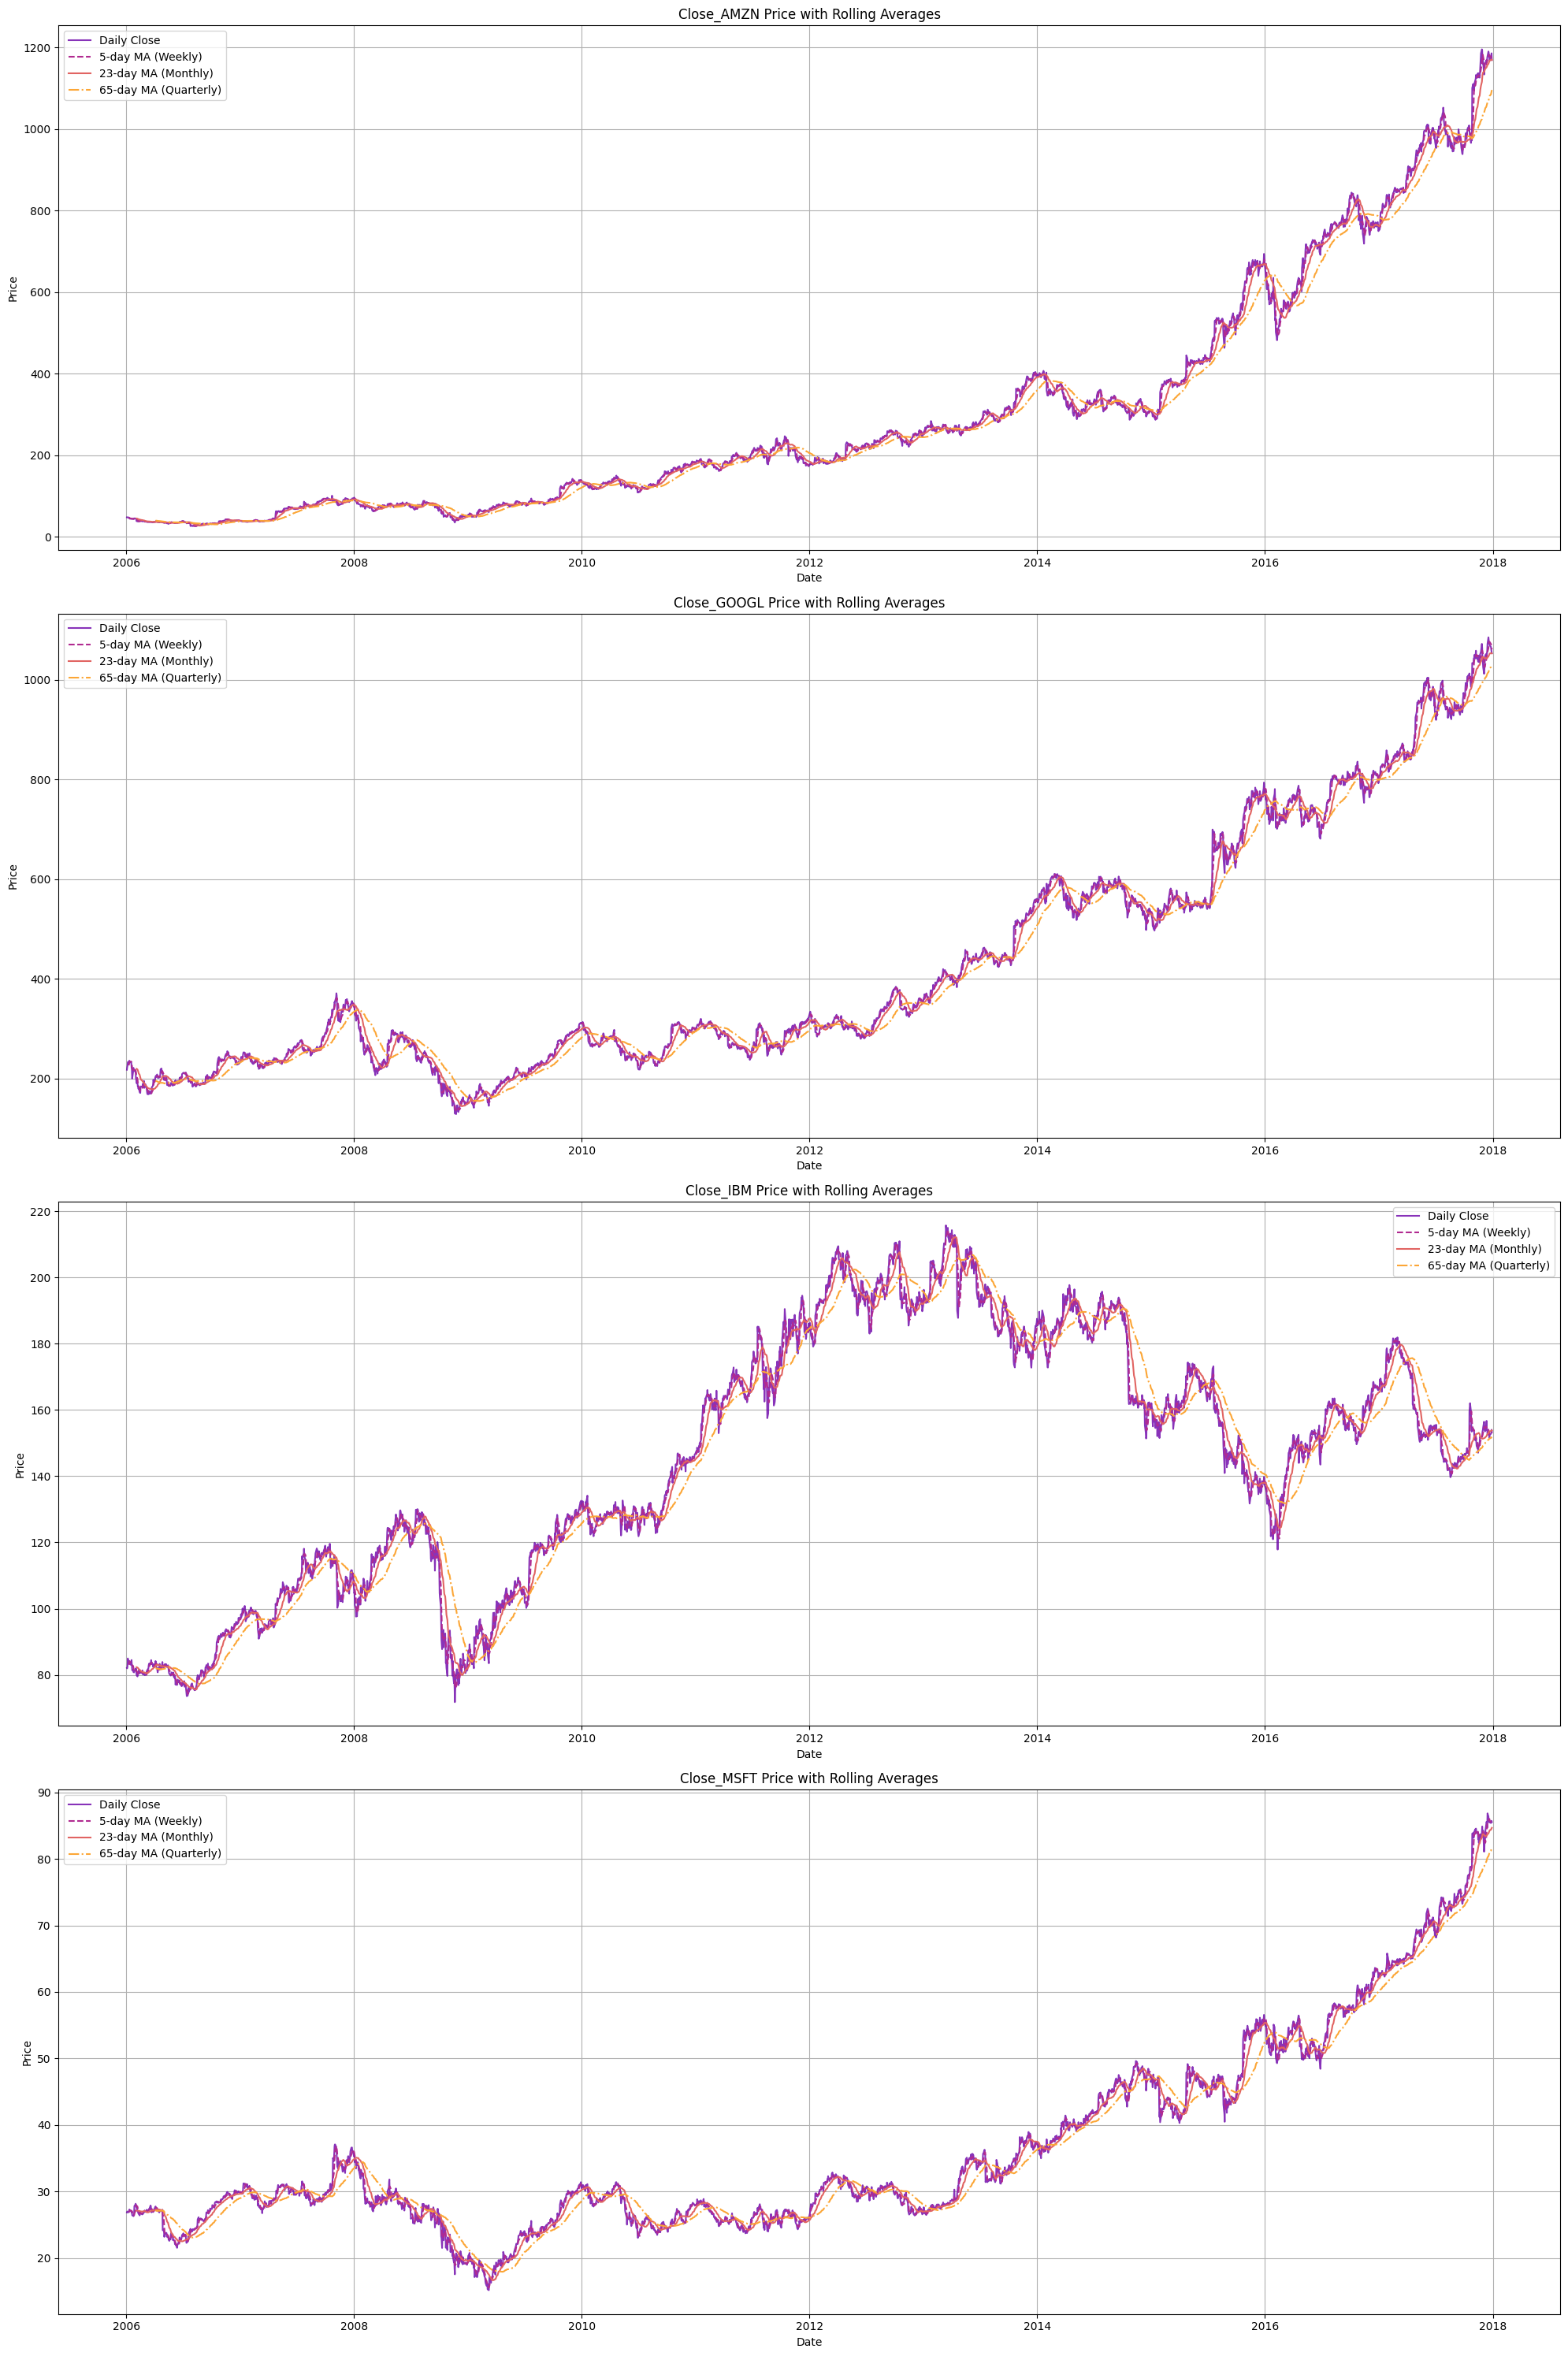

In [55]:
# Plotting for all the companies together to check the trend

plt.figure(figsize=(20, 30))
colors = sns.color_palette("plasma", 4)

for i, (col, company) in enumerate(zip(close_cols, companies), 1):
    plt.subplot(len(close_cols), 1, i)

    plt.plot(Stock_Price_Joined_df['Date'], Stock_Price_Joined_df[col], label='Daily Close', color=colors[0], alpha=0.8)
    plt.plot(Stock_Price_Joined_df['Date'], Stock_Price_Joined_df[col].rolling(window=weekly_window).mean(),
             label=f'{weekly_window}-day MA (Weekly)', color=colors[1], linestyle='--')
    plt.plot(Stock_Price_Joined_df['Date'], Stock_Price_Joined_df[col].rolling(window=monthly_window).mean(),
             label=f'{monthly_window}-day MA (Monthly)', color=colors[2],  linestyle='-')
    plt.plot(Stock_Price_Joined_df['Date'], Stock_Price_Joined_df[col].rolling(window=quarterly_window).mean(),
             label=f'{quarterly_window}-day MA (Quarterly)', color=colors[3],  linestyle='-.')

    plt.title(f'{company} Price with Rolling Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

We can see from above graph that we are getting a good time series line when we adjusted a window size of a Month. <br>
For this case we have taken 23 Business days to perform the Monthly calculation. <br>
##### Hence, we can consider a window size of 21-25 days for our Model building

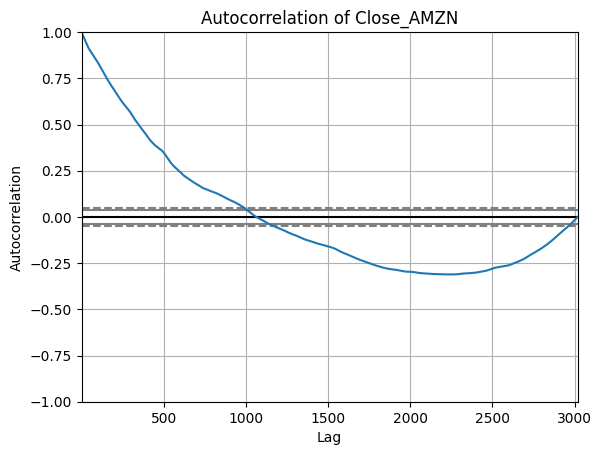

In [56]:
# Verifying randomness in the data
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(sp_df['Close_AMZN'])
plt.title("Autocorrelation of Close_AMZN")
plt.show()

### <b>Conclusion : </b> Based on above graphs we can say that, <br>
-- 5-Business day MA(Moving Avg.) is too volatile for trend tracking.<br>
-- <b>23-day</b>  (Monthly) offers the <b>good</b> trade-off between noise reduction and trend responsiveness. <br>
-- 65-day MA smooths too much and flatten the graph.Hence, Prediction may go wrong because it wont be able to catch the trends


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [57]:
# Create data instances from the master data frame using decided window size and window stride

df=Stock_Price_Joined_df
target_cols=['Close_AMZN']
window_size=23
step_size=1
train_split_ratio=0.8

X_train, y_train, X_test, y_test, X_scaler, y_scaler = prepare_data_main(
    df, target_cols, window_size, step_size, train_split_ratio
)

In [58]:
# Check the number of data points generated
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (2396, 23, 20), y_train shape: (2396, 1)
X_test shape: (599, 23, 20), y_test shape: (599, 1)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [59]:
# Check if the datasets are compatible inputs to neural networks

# Checking by shape
print("X shape (samples, timesteps, features):", X_train.shape)
print("y shape (samples, targets):", y_train.shape)

X shape (samples, timesteps, features): (2396, 23, 20)
y shape (samples, targets): (2396, 1)


##### RNN expects X to be 3D: (samples, timesteps, features) And y to be 2D: (samples, target_dim)
##### Hence, as per RNN concepts our Data frames are in correct format.

In [60]:
# Checking compatibility by all other parameters

def check_rnn_input(x, y):
    assert isinstance(x, np.ndarray), "x is not a numpy array"
    assert len(x.shape) == 3, "x must be 3D: (samples, timesteps, features)"
    assert x.shape[0] == y.shape[0], "x and y sample counts do not match"
    assert not np.isnan(x).any(), "x contains NaNs"
    assert not np.isinf(x).any(), "x contains Infs"
    print("✅ Input data is RNN-ready!")

check_rnn_input(X_train, y_train)

✅ Input data is RNN-ready!


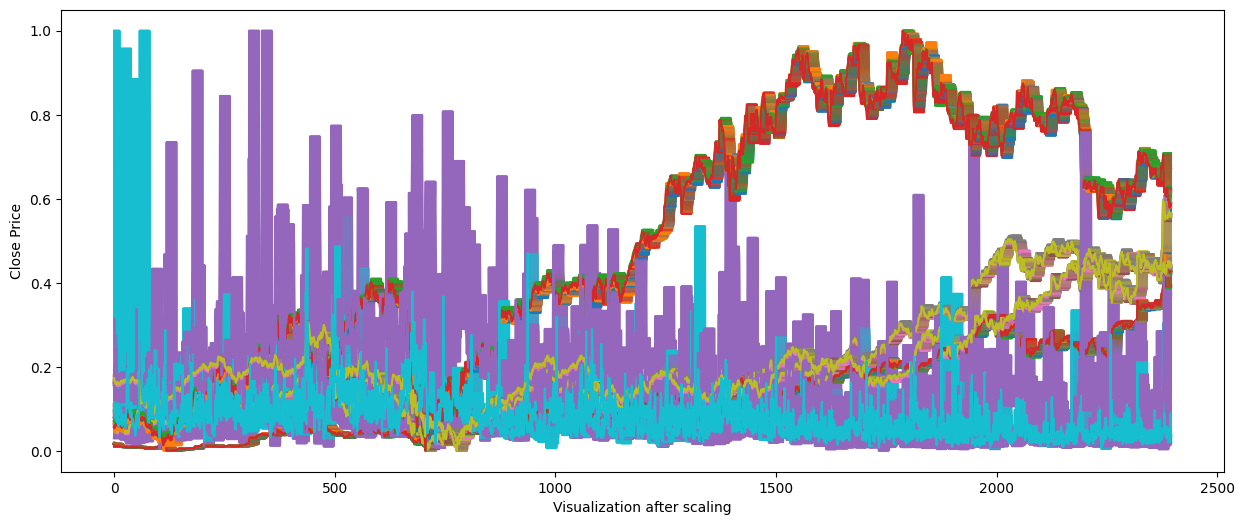

In [61]:
# Visualization after scaling
plt.subplots(figsize = (15,6))
plt.plot(X_train.reshape(X_train.shape[0], -1))
plt.xlabel("Visualization after scaling")
plt.ylabel("Close Price")
plt.show()

## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [62]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def build_simple_rnn_model(input_shape, output_shape, units=[50], dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()

    # Add RNN layers
    for i, unit in enumerate(units):
        return_sequences = i < len(units) - 1  # Return sequences for all but last layer
        if i == 0:
            # First layer needs input_shape
            model.add(SimpleRNN(units=unit,
                               return_sequences=return_sequences,
                               input_shape=input_shape))
        else:
            model.add(SimpleRNN(units=unit, return_sequences=return_sequences))

        # Add dropout after each RNN layer
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(output_shape))

    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    return model


In [63]:
# Sample code to test the new function build_simple_rnn_model and to view the summary
input_shape = (X_train.shape[1], X_train.shape[2]) # (timesteps, features)
output_shape = y_train.shape[1]

rnn_model = build_simple_rnn_model(input_shape, output_shape, units = [32,64], dropout_rate=0.2, learning_rate=0.001)
rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 23, 32)         │         1,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,969 (31.13 KB)

 Trainable params: 7,969 (31.13 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Creating a dataset to fetch columns related to the stock name
def fetch_individual_stock_columns(df, stock_name):
  columns = [col for col in df.columns if col.endswith(stock_name)]
  selected_columns = ['Date'] + columns
  return df[selected_columns]

In [65]:
# Creating function to display the MSE, RMSE and R2 Value
def print_model_evaluation_metrics(model, X_test, y_test, y_pred):
    model.summary()
    loss = model.evaluate(X_test, y_test)
    print()
    print(f"Test Loss (MSE): {loss}")
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")


# Creating function to plot the differences for Actual and Predicted
def plot_actual_vs_predicted(y_test, y_pred, y_scaler, stock_name):
    y_pred_inv = y_scaler.inverse_transform(y_pred)
    y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))
    colors = sns.color_palette("plasma", 2)
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inv, label='Actual', color=colors[0])
    plt.plot(y_pred_inv, label='Predicted', color=colors[1])
    plt.title('Actual vs Predicted Closing Prices for '+stock_name)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [66]:
# Creating function which calls prepare_data_main, build_simple_rnn_model, print_model_evaluation_metrics,
# plot_actual_vs_predicted functions to showcase how Simple RNN Model is performing

def evaluate_simple_rnn_model(df, stock_name, window_size = 20, step_size =1, train_ratio=0.8,
                            batch_size = 32, epoch_num=10, rnn_units=50,
                            learning_rate=0.001, dropout_rate =0.1):

    stock_specific_df = fetch_individual_stock_columns(df, stock_name)
    target_cols = 'Close_'+stock_name

    X_train, y_train, X_test, y_test, X_scaler, y_scaler = prepare_data_main(
        stock_specific_df,
        target_cols,
        window_size= window_size,
        step_size=step_size,
        train_split_ratio=train_ratio
    )

    input_shape  = (X_train.shape[1], X_train.shape[2])
    output_shape = y_train.shape[1]
    simple_rnn_model = build_simple_rnn_model(input_shape, output_shape, units = [rnn_units], dropout_rate=0.2, learning_rate=0.001)
    # Train the model
    simple_rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs= epoch_num, batch_size=batch_size)

    print('='*100)
    print()

    y_pred_simple = simple_rnn_model.predict(X_test)
    print_model_evaluation_metrics(simple_rnn_model, X_test, y_test, y_pred_simple)

    print('='*100)
    display(Markdown('### Plot for **Actual vs Predicted** values for Simple RNN'))
    print()

    plot_actual_vs_predicted(y_test, y_pred_simple, y_scaler, stock_name)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0098 - val_loss: 0.1061
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - val_loss: 0.0705
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0588e-04 - val_loss: 0.0433
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8065e-04 - val_loss: 0.0251
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2249e-04 - val_loss: 0.0141
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1872e-04 - val_loss: 0.0136
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3171e-04 - val_loss: 0.0052
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9700e-04 - val_loss: 0.0049
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2431e-04 - val_loss: 0.0038
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9707e-04 - val_loss: 0.0026

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 50)             │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,555 (33.42 KB)

 Trainable params: 2,851 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,704 (22.29 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011     

Test Loss (MSE): 0.0025661487597972155
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE: 0.0026
RMSE: 0.0507
R² Score: 0.8908


### Plot for **Actual vs Predicted** values for Simple RNN

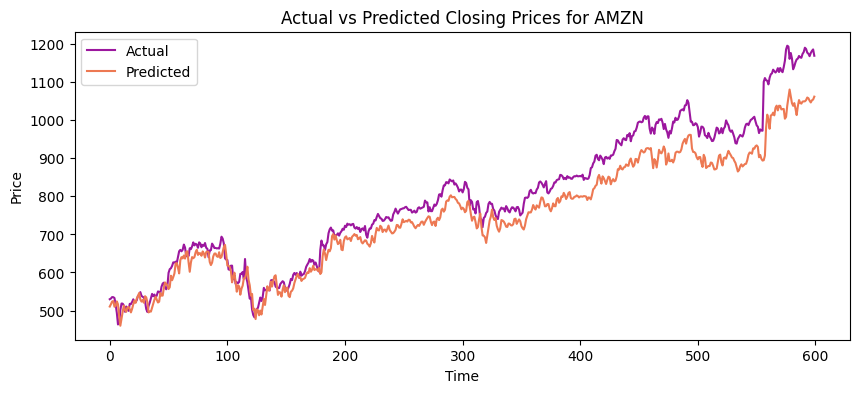

In [67]:
# Simple RNN model for AMZN

evaluate_simple_rnn_model(df, 'AMZN', window_size = 20, step_size =1,
                         train_ratio=0.8, batch_size = 32, epoch_num=10)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0122 - val_loss: 0.0124
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 0.0044
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.6084e-04 - val_loss: 0.0011
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9484e-04 - val_loss: 8.2448e-04
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6767e-04 - val_loss: 9.7831e-04
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9258e-04 - val_loss: 8.7027e-04
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0384e-04 - val_loss: 5.4783e-04
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6152e-04 - val_loss: 0.0011
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0013e-04 - val_loss: 4.7492e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 50)             │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,555 (33.42 KB)

 Trainable params: 2,851 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,704 (22.29 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6979e-04 

Test Loss (MSE): 0.00047491546138189733
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE: 0.0005
RMSE: 0.0218
R² Score: 0.9657


### Plot for **Actual vs Predicted** values for Simple RNN

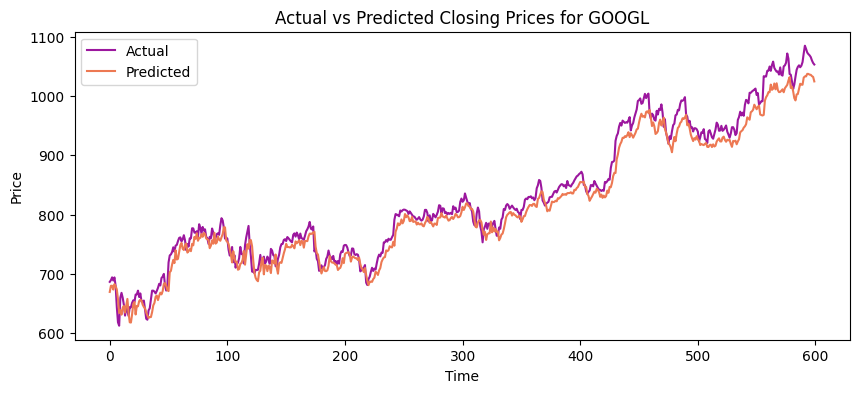

In [68]:
# Simple RNN model for GOOGL

evaluate_simple_rnn_model(df, 'GOOGL', window_size = 20, step_size =1,
                         train_ratio=0.8, batch_size = 32, epoch_num=10)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3354 - val_loss: 0.0034
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0245 - val_loss: 0.0021
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0142 - val_loss: 0.0016
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0106 - val_loss: 9.3604e-04
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 8.0079e-04
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 7.1344e-04
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 5.8839e-04
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 5.9958e-04
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 5.1583e-04
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 5.3908e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 50)             │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,555 (33.42 KB)

 Trainable params: 2,851 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,704 (22.29 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9343e-04 

Test Loss (MSE): 0.0005390761652961373
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE: 0.0005
RMSE: 0.0232
R² Score: 0.9268


### Plot for **Actual vs Predicted** values for Simple RNN

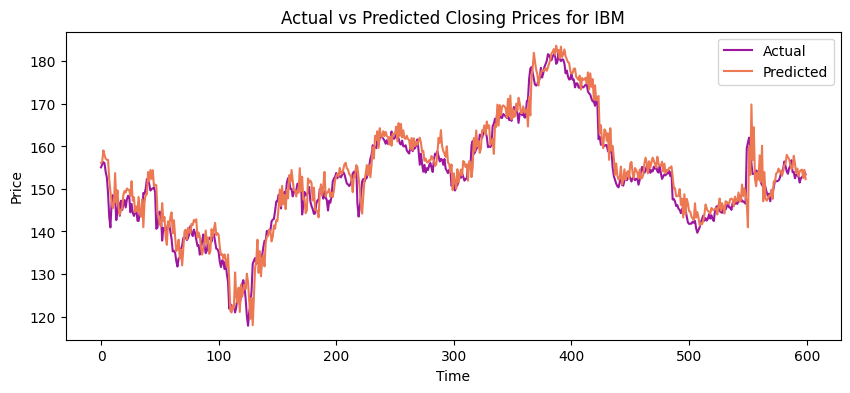

In [69]:
# Simple RNN model for IBM

evaluate_simple_rnn_model(df, 'IBM', window_size = 20, step_size =1,
                         train_ratio=0.8, batch_size = 32, epoch_num=10)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1114 - val_loss: 0.0652
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0327
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0192
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0145
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0106
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - val_loss: 0.0061
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8001e-04 - val_loss: 0.0052
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5354e-04 - val_loss: 0.0033

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_5 (SimpleRNN)        │ (None, 50)             │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,555 (33.42 KB)

 Trainable params: 2,851 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,704 (22.29 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013     

Test Loss (MSE): 0.0033455186057835817
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE: 0.0033
RMSE: 0.0578
R² Score: 0.8516


### Plot for **Actual vs Predicted** values for Simple RNN

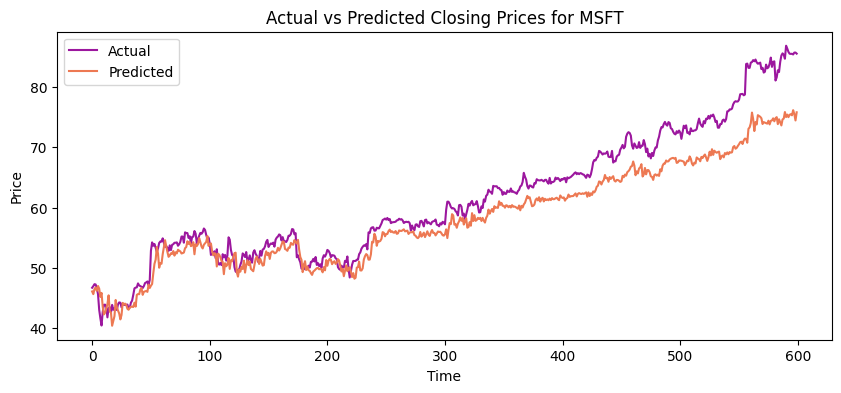

In [70]:
# Simple RNN model for MSFT

evaluate_simple_rnn_model(df, 'MSFT', window_size = 20, step_size =1,
                         train_ratio=0.8, batch_size = 32, epoch_num=10)

From Above Prediction we received below statistics about our Simple RNN Model

|Simple RNN WO HP | AMZN   | GOOGL  | IBM      | MSFT   |
|---------------|----------|--------|----------|--------|
| MSE           | 0.0026   | 0.0005 | 0.0005   | 0.0033 |
| RMSE          | 0.0507   | 0.0218 | 0.0232   | 0.0578 |
| R² Score      | 0.8908   | 0.9657 | 0.9268   | 0.8516 |

** WO HP -- Without Hyperparamater

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [71]:
# Find an optimal configuration of simple RNN

def rnn_model_with_hp_tuning(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    # Define early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
        validation_split=0.2, callbacks=[early_stopping], verbose=1
    )

    # Evaluate on test data
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {
        'history': history,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred
    }

In [72]:
# Find the best configuration based on evaluation metrics
rnn_results = []

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Define hyperparameter grid
unit_configs = [[32], [64], [128], [32, 32], [64, 32]]
dropout_rates = [0.2, 0.3, 0.5]
learning_rates = [0.001, 0.01]

# Prepare input shape
input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = y_train.shape[1]

# Run grid search
for units in unit_configs:
    for dropout_rate in dropout_rates:
        for lr in learning_rates:
            print(f"\nTraining Simple RNN with units={units}, dropout={dropout_rate}, lr={lr}")

            # Build model
            model = build_simple_rnn_model(input_shape=input_shape, output_shape=output_shape,
                units=units, dropout_rate=dropout_rate, learning_rate=lr
            )


            # Train and evaluate
            result = rnn_model_with_hp_tuning(model=model, X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test, epochs=50, batch_size=32
            )

            # Store results
            result['config'] = {
                'type': 'SimpleRNN',
                'units': units,
                'dropout_rate': dropout_rate,
                'learning_rate': lr
            }
            rnn_results.append(result)

            print(f"MSE: {result['mse']:.4f}, MAE: {result['mae']:.4f}, R²: {result['r2']:.4f}")

# Find the best configuration based on MSE
best_rnn = min(rnn_results, key=lambda x: x['mse'])
print("\nBest Simple RNN Configuration:")
print(f"Units: {best_rnn['config']['units']}")
print(f"Dropout: {best_rnn['config']['dropout_rate']}")
print(f"Learning Rate: {best_rnn['config']['learning_rate']}")
print(f"MSE: {best_rnn['mse']:.4f}")
print(f"MAE: {best_rnn['mae']:.4f}")
print(f"R²: {best_rnn['r2']:.4f}")


Training Simple RNN with units=[32], dropout=0.2, lr=0.001
Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0501 - val_loss: 0.0071
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0141 - val_loss: 0.0065
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088 - val_loss: 0.0073
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0064
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0060
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 0.0077
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_loss: 0.0043
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 0.0051
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 12/50
6

As we saw that we finally got the Optimal parameters for building the simple RNN. <br>
#### Best Hyperparameters: <br>
Units: [64] <br>
Dropout Rate: 0.3 <br>
Learning Rate: 0.001

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2009e-04 - val_loss: 0.0047
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4509e-04 - val_loss: 0.0036
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8784e-04 - val_loss: 0.0013
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3180e-04 - val_loss: 0.0011
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0800e-04 - val_loss: 9.3317e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6706e-04 - val_loss: 0.0011
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3488e-04 - val_loss: 0.0027
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2582e-04 - val_loss: 0.0019
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3401e-04 - val_loss: 0.0016
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9852e-04 - val_loss: 0.0011
Epoch 12/20
75/75 ━━━━━━━━━━━━

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_48 (SimpleRNN)       │ (None, 64)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,637 (53.27 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,092 (35.52 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3585e-04 

Test Loss (MSE): 0.001140223233960569
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE: 0.0011
RMSE: 0.0338
R² Score: 0.9515


### Plot for **Actual vs Predicted** values for Simple RNN

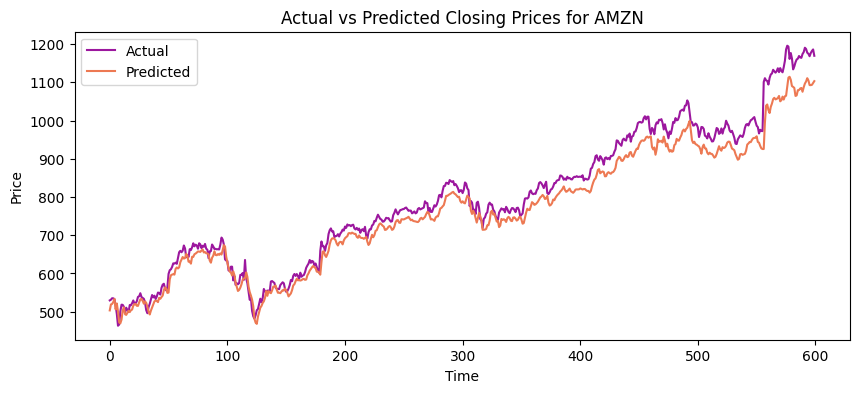

In [73]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

# Simple RNN model for AMZN Closing Price with optimal hyperparameter values
evaluate_simple_rnn_model(df, 'AMZN', window_size = 20, step_size =1,
                         train_ratio=0.8, batch_size = 32, epoch_num=20,
                         rnn_units=64, learning_rate=0.001, dropout_rate =0.3)



Plotting the actual vs predicted values

In [74]:
# Predict on the test data and plot
# Predicting for all companies Closing prices to perceive better visibility

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0149 - val_loss: 0.0197
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 0.0055
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.7788e-04 - val_loss: 0.0021
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5467e-04 - val_loss: 0.0018
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8644e-04 - val_loss: 0.0022
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4897e-04 - val_loss: 4.0956e-04
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9728e-04 - val_loss: 0.0030
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4011e-04 - val_loss: 2.5577e-04
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4627e-04 - val_loss: 4.7747e-04
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_49 (SimpleRNN)       │ (None, 64)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,637 (53.27 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,092 (35.52 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8678e-04 

Test Loss (MSE): 0.00015183162759058177
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE: 0.0002
RMSE: 0.0123
R² Score: 0.9890


### Plot for **Actual vs Predicted** values for Simple RNN

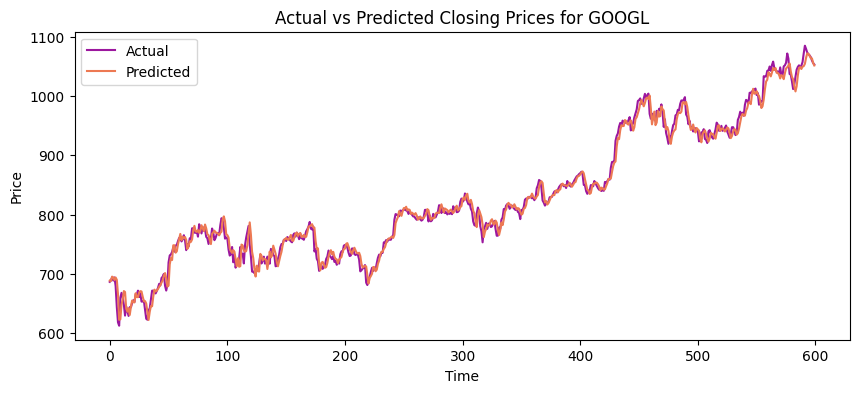

In [75]:
# Simple RNN model for GOOGL Closing Price with optimal hyperparameter values

evaluate_simple_rnn_model(df, 'GOOGL', window_size = 20, step_size =1,
                         train_ratio=0.8, batch_size = 32, epoch_num=20,
                         rnn_units=64, learning_rate=0.001, dropout_rate =0.3)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1061 - val_loss: 0.0029
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0113 - val_loss: 0.0022
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 9.7457e-04
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 6.0522e-04
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 8.4040e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 5.8364e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 4.4917e-04
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 3.9799e-04
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 4.7285e-04
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 5.1576e-04
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_50 (SimpleRNN)       │ (None, 64)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,637 (53.27 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,092 (35.52 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6790e-04 

Test Loss (MSE): 0.0004412110720295459
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE: 0.0004
RMSE: 0.0210
R² Score: 0.9401


### Plot for **Actual vs Predicted** values for Simple RNN

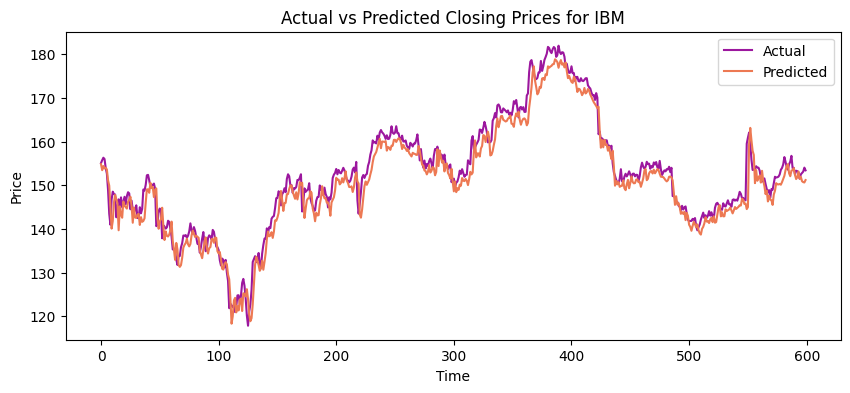

In [76]:
# Simple RNN model for IBM Closing Price with optimal hyperparameter values
evaluate_simple_rnn_model(df, 'IBM', window_size = 20, step_size =1,
                         train_ratio=0.8, batch_size = 32, epoch_num=20,
                         rnn_units=64, learning_rate=0.001, dropout_rate =0.3)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0128 - val_loss: 0.0220
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 0.0120
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 0.0054
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0441e-04 - val_loss: 0.0018
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8828e-04 - val_loss: 0.0013
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7135e-04 - val_loss: 5.8648e-04
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8505e-04 - val_loss: 0.0015
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0699e-04 - val_loss: 9.3563e-04
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1378e-04 - val_loss: 9.4855e-04
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9926e-04 - val_loss: 0.0021
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_51 (SimpleRNN)       │ (None, 64)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,637 (53.27 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,092 (35.52 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5544e-04 

Test Loss (MSE): 0.00031873094849288464
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE: 0.0003
RMSE: 0.0179
R² Score: 0.9859


### Plot for **Actual vs Predicted** values for Simple RNN

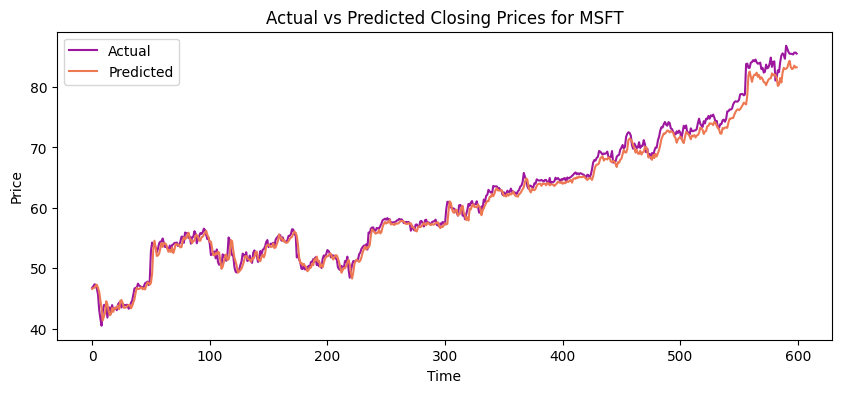

In [77]:
# Simple RNN model for MSFT Closing Price with optimal hyperparameter values
evaluate_simple_rnn_model(df, 'MSFT', window_size = 20, step_size =1,
                         train_ratio=0.8, batch_size = 32, epoch_num=20,
                         rnn_units=64, learning_rate=0.001, dropout_rate =0.3)


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [78]:
# Compute the performance of the model on the testing data set

As per above computation we have received the following results.

|Simple RNN WO HP | AMZN   | GOOGL  | IBM      | MSFT   |
|---------------|----------|--------|----------|--------|
| MSE           | 0.0026   | 0.0005 | 0.0005   | 0.0033 |
| RMSE          | 0.0507   | 0.0218 | 0.0232   | 0.0578 |
| R² Score      | 0.8908   | 0.9657 | 0.9268   | 0.8516 |

** WO HP -- Without Hyperparamater
<br>-------------------------------------------------------------------------

|Simple RNN with HP | AMZN   | GOOGL  | IBM      | MSFT   |
|---------------|----------|--------|----------|--------|
| MSE           | 0.0011   | 0.0002 | 0.0004   | 0.0003 |
| RMSE          | 0.0338   | 0.0123 | 0.0210  | 0.0179 |
| R² Score      | 0.9515   | 0.9890 | 0.9401   | 0.9859 |

** HP -- Hyperparamater

### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [79]:
# Define a function to create a model and specify default values for hyperparameters

def build_advanced_RNN_Model(input_shape, output_shape, rnn_type='LSTM', units=[64],
                      dropout_rate=0.3, learning_rate=0.001):

    model = Sequential()

    # Choose RNN layer type
    if rnn_type == 'LSTM':
        RNNLayer = LSTM
    elif rnn_type == 'GRU':
        RNNLayer = GRU
    else:
        raise ValueError("rnn_type must be either 'LSTM' or 'GRU'")

    # Add RNN layers
    for i, unit in enumerate(units):
        return_sequences = i < len(units) - 1  # Return sequences for all but last layer
        if i == 0:
            # First layer needs input_shape
            model.add(RNNLayer(units=unit,
                              return_sequences=return_sequences,
                              input_shape=input_shape))
        else:
            model.add(RNNLayer(units=unit, return_sequences=return_sequences))

        # Add dropout after each RNN layer
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(output_shape))

    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    return model



In [80]:
# Sample code to test the new function build_advanced_RNN_Modelfor Advanced RNN and to view the summary
model = build_advanced_RNN_Model(input_shape, output_shape)

tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [81]:
model.summary()

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,825 (85.25 KB)

 Trainable params: 21,825 (85.25 KB)

 Non-trainable params: 0 (0.00 B)

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [82]:
# Find an optimal configuration

# Grid search for advanced RNN models
adv_rnn_results = []

# Define hyperparameter grid
rnn_types = ['LSTM', 'GRU']
unit_configs = [[64], [128], [64, 32], [128, 64]]
dropout_rates = [0.1, 0.2, 0.3]
learning_rates = [0.001, 0.005]

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Run grid search
for rnn_type in rnn_types:
    for units in unit_configs:
        for dropout_rate in dropout_rates:
            for lr in learning_rates:
                print(f"\nTraining {rnn_type} with units={units}, dropout={dropout_rate}, lr={lr}")


                # Build model
                model = build_advanced_RNN_Model( input_shape=input_shape, output_shape=output_shape,
                    rnn_type=rnn_type, units=units, dropout_rate=dropout_rate, learning_rate=lr
                )

                # Train and evaluate
                result = rnn_model_with_hp_tuning(model=model, X_train=X_train, y_train=y_train,
                    X_test=X_test, y_test=y_test, epochs=50, batch_size=32
                )

                # Store results
                result['config'] = {
                    'type': rnn_type,
                    'units': units,
                    'dropout_rate': dropout_rate,
                    'learning_rate': lr
                }
                adv_rnn_results.append(result)

                print(f"MSE: {result['mse']:.4f}, MAE: {result['mae']:.4f}, R²: {result['r2']:.4f}")

# Find the best configuration based on MSE
best_adv_rnn = min(adv_rnn_results, key=lambda x: x['mse'])
print("\nBest Advanced RNN Configuration:")
print(f"Type: {best_adv_rnn['config']['type']}")
print(f"Units: {best_adv_rnn['config']['units']}")
print(f"Dropout: {best_adv_rnn['config']['dropout_rate']}")
print(f"Learning Rate: {best_adv_rnn['config']['learning_rate']}")
print(f"MSE: {best_adv_rnn['mse']:.4f}")
print(f"MAE: {best_adv_rnn['mae']:.4f}")
print(f"R²: {best_adv_rnn['r2']:.4f}")




Training LSTM with units=[64], dropout=0.1, lr=0.001
Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0029 - val_loss: 0.0048
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8537e-04 - val_loss: 8.7771e-04
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5562e-04 - val_loss: 0.0016
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8103e-04 - val_loss: 4.1067e-04
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.4818e-04 - val_loss: 4.5061e-04
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2303e-04 - val_loss: 2.9026e-04
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.9422e-05 - val_loss: 4.6657e-04
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0169e-04 - val_loss: 4.2041e-04
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.3828e-05 - val_loss: 3.3698e-04
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.9209e-05 - val_loss: 2.2208e-04
Epoch 11/50
60/60 ━━━━━━━━━

As we saw that we finally got the Optimal parameters for building the Advanced RNN. <br>
#### Best Hyperparameters: <br>
Type: GRU <br>
Units: [128] <br>
Dropout: 0.1 <br>
Learning Rate: 0.005

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [83]:
# Using the best parameters identified in the previous step
best_type = best_adv_rnn['config']['type']
best_units = best_adv_rnn['config']['units']
best_dropout = best_adv_rnn['config']['dropout_rate']
best_lr = best_adv_rnn['config']['learning_rate']


In [84]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

# Reset the session for clean training
tf.keras.backend.clear_session()

def evaluate_advanced_RNN_best_model(df, stock_name, window_size = 20, step_size =1, train_ratio=0.8,
                                    batch_size = 32, epoch_num=10, rnn_type='LSTM', rnn_units=128,
                                    learning_rate=0.005, dropout_rate =0.2):

    stock_specific_df = fetch_individual_stock_columns(df, stock_name)
    target_cols = 'Close_'+stock_name

    X_train, y_train, X_test, y_test, X_scaler, y_scaler = prepare_data_main(
        stock_specific_df,
        target_cols,
        window_size= window_size,
        step_size=step_size,
        train_split_ratio=train_ratio
    )

    window_size = X_train.shape[1]
    num_features = X_train.shape[2]
    input_shape  = (X_train.shape[1], X_train.shape[2])
    output_shape = y_train.shape[1]

    adv_rnn_model = build_advanced_RNN_Model(input_shape, output_shape, rnn_type, units=[rnn_units],
                      dropout_rate=dropout_rate, learning_rate=learning_rate)


    # Train the model
    adv_rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch_num, batch_size=batch_size)
    print('='*90)
    print()


    # Compute the performance of the model on the testing data set
    y_pred_adv_rnn = adv_rnn_model.predict(X_test)
    print_model_evaluation_metrics(adv_rnn_model, X_test, y_test, y_pred_adv_rnn)

    print('='*90)
    display(Markdown('## Plot for **Actual vs Predicted** values for Advanced RNN'))
    print()

    plot_actual_vs_predicted(y_test, y_pred_adv_rnn, y_scaler, stock_name)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0031 - val_loss: 2.3836e-04
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.4009e-05 - val_loss: 1.8474e-04
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.8822e-05 - val_loss: 1.6293e-04
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.9096e-05 - val_loss: 2.3085e-04
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.1459e-05 - val_loss: 3.0835e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.5758e-05 - val_loss: 2.8485e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.5354e-05 - val_loss: 1.5233e-04
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6863e-05 - val_loss: 1.3808e-04
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.1654e-05 - val_loss: 5.9612e-04
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.3144e-05 - val_loss: 1.6433e-04
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.8424e-05 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,909 (609.02 KB)

 Trainable params: 51,969 (203.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 103,940 (406.02 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1025e-04

Test Loss (MSE): 0.00011572770745260641
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE: 0.0001
RMSE: 0.0108
R² Score: 0.9951


## Plot for **Actual vs Predicted** values for Advanced RNN

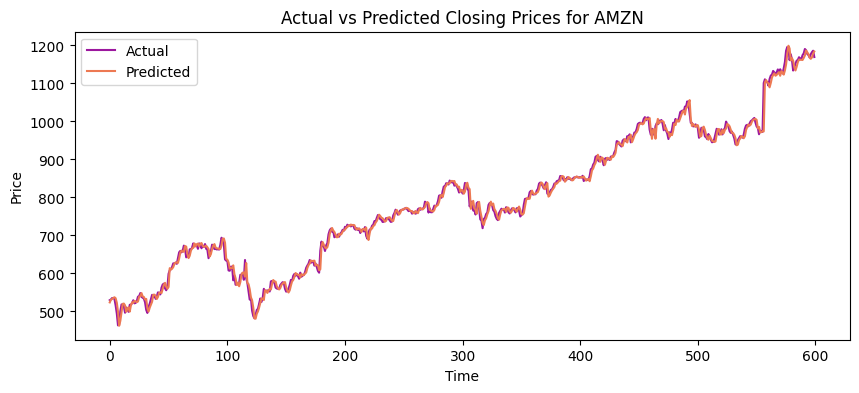

In [85]:
# Compute the performance of the model on the testing data set

# Advanced RNN model for AMZN Closing Price after performing Hyperparameter Tuning
evaluate_advanced_RNN_best_model(df, 'AMZN', window_size = 20, step_size =1, train_ratio=0.8,
                          batch_size = 32, epoch_num=20, rnn_type=best_type,
                          learning_rate=best_lr, dropout_rate =best_dropout)


Plotting the actual vs predicted values

In [86]:
# Predict on the test data
# Predicting for all companies Closing prices to perceive better visibility and to perform comparison

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0075 - val_loss: 2.5153e-04
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.9926e-04 - val_loss: 1.9131e-04
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.4089e-04 - val_loss: 1.4875e-04
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.4312e-04 - val_loss: 2.3456e-04
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.5753e-04 - val_loss: 5.5799e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.4026e-04 - val_loss: 1.7536e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.3802e-04 - val_loss: 5.5475e-04
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.4689e-04 - val_loss: 1.5470e-04
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.2401e-04 - val_loss: 1.2413e-04
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.1691e-04 - val_loss: 1.5010e-04
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.1490e-04 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 128)            │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,909 (609.02 KB)

 Trainable params: 51,969 (203.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 103,940 (406.02 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8164e-04

Test Loss (MSE): 0.00015678790805395693
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE: 0.0002
RMSE: 0.0125
R² Score: 0.9887


## Plot for **Actual vs Predicted** values for Advanced RNN

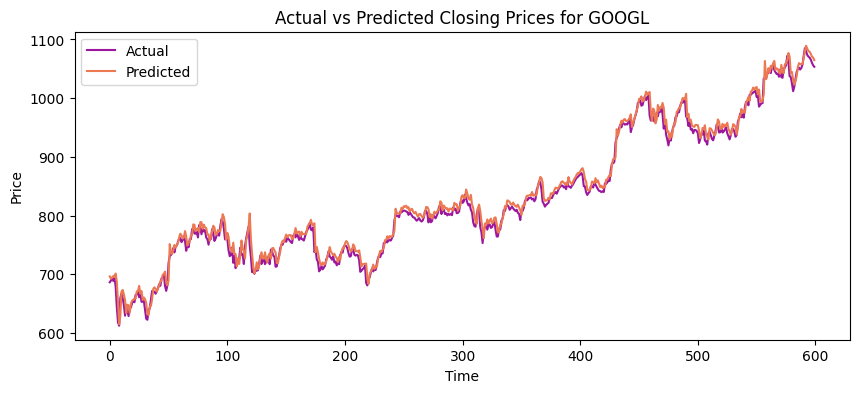

In [87]:
# Advanced RNN model for GOOGL Closing Price after performing Hyperparameter Tuning
evaluate_advanced_RNN_best_model(df, 'GOOGL', window_size = 20, step_size =1, train_ratio=0.8,
                          batch_size = 32, epoch_num=20, rnn_type=best_type,
                          learning_rate=best_lr, dropout_rate =best_dropout)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0254 - val_loss: 5.6036e-04
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011 - val_loss: 2.0328e-04
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.5281e-04 - val_loss: 2.0051e-04
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.2602e-04 - val_loss: 2.3068e-04
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.1181e-04 - val_loss: 2.5902e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.7879e-04 - val_loss: 2.5992e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.9221e-04 - val_loss: 2.9210e-04
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.8905e-04 - val_loss: 4.9563e-04
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6737e-04 - val_loss: 1.8017e-04
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.8756e-04 - val_loss: 1.7713e-04
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.3088e-04 - val_

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 128)            │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,909 (609.02 KB)

 Trainable params: 51,969 (203.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 103,940 (406.02 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8100e-04

Test Loss (MSE): 0.00037769286427646875
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE: 0.0004
RMSE: 0.0194
R² Score: 0.9487


## Plot for **Actual vs Predicted** values for Advanced RNN

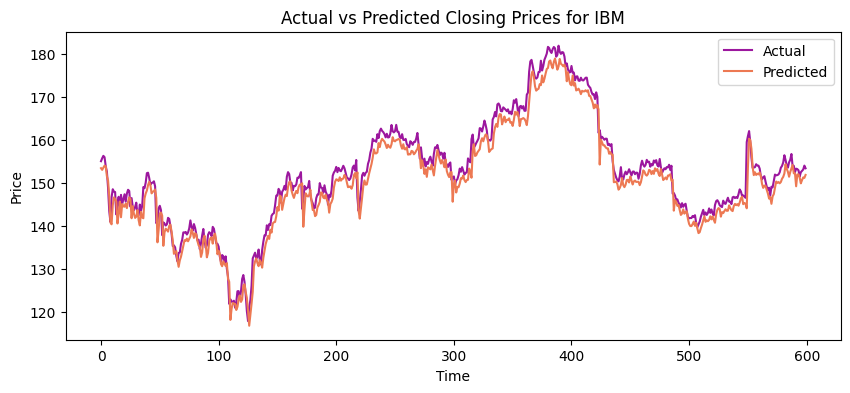

In [88]:
# Advanced RNN model for IBM Closing Price after performing Hyperparameter Tuning
evaluate_advanced_RNN_best_model(df, 'IBM', window_size = 20, step_size =1, train_ratio=0.8,
                          batch_size = 32, epoch_num=20, rnn_type=best_type,
                          learning_rate=best_lr, dropout_rate =best_dropout)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0048 - val_loss: 1.7558e-04
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.8474e-04 - val_loss: 1.4476e-04
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.5018e-04 - val_loss: 1.8974e-04
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.5402e-04 - val_loss: 1.6077e-04
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.4365e-04 - val_loss: 1.4840e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.2601e-04 - val_loss: 5.3985e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.4030e-04 - val_loss: 1.3857e-04
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.3185e-04 - val_loss: 1.2957e-04
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0708e-04 - val_loss: 2.0975e-04
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0387e-04 - val_loss: 1.8247e-04
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0836e-04 - 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 128)            │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,909 (609.02 KB)

 Trainable params: 51,969 (203.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 103,940 (406.02 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1811e-04

Test Loss (MSE): 0.0004569965531118214
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE: 0.0005
RMSE: 0.0214
R² Score: 0.9797


## Plot for **Actual vs Predicted** values for Advanced RNN

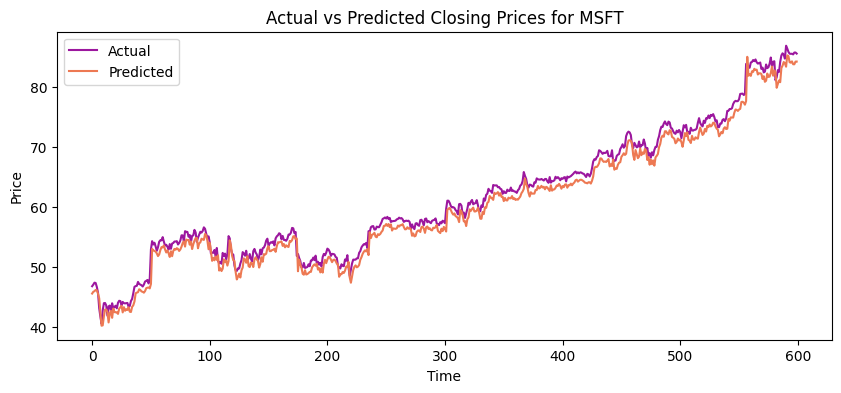

In [89]:
# Advanced RNN model for MSFT Closing Price after performing Hyperparameter Tuning
evaluate_advanced_RNN_best_model(df, 'MSFT', window_size = 20, step_size =1, train_ratio=0.8,
                          batch_size = 32, epoch_num=20, rnn_type=best_type,
                          learning_rate=best_lr, dropout_rate =best_dropout)


As per above computation we get the below result

|Simple RNN WO HP | AMZN   | GOOGL  | IBM      | MSFT   |
|---------------|----------|--------|----------|--------|
| MSE           | 0.0026   | 0.0005 | 0.0005   | 0.0033 |
| RMSE          | 0.0507   | 0.0218 | 0.0232   | 0.0578 |
| R² Score      | 0.8908   | 0.9657 | 0.9268   | 0.8516 |

** WO HP -- Without Hyperparamater
<br>-------------------------------------------------------------------------

|Simple RNN with HP | AMZN   | GOOGL  | IBM      | MSFT   |
|---------------|----------|--------|----------|--------|
| MSE           | 0.0011   | 0.0002 | 0.0004   | 0.0003 |
| RMSE          | 0.0338   | 0.0123 | 0.0210  | 0.0179 |
| R² Score      | 0.9515   | 0.9890 | 0.9401   | 0.9859 |

** HP -- Hyperparamater
<br>-------------------------------------------------------------------------

|Adv RNN with HP | AMZN   | GOOGL  | IBM      | MSFT   |
|---------------|----------|--------|----------|--------|
| MSE           | 0.0001   | 0.0002 | 0.0004   | 0.0005 |
| RMSE          | 0.0108   | 0.0125 | 0.0194  | 0.0214 |
| R² Score      | 0.9951   | 0.9887 | 0.9487   | 0.9797 |

** HP -- Hyperparamater

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [90]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [91]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [92]:
# Find an optimal configuration of simple RNN



In [93]:
# Find the best configuration



In [94]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [95]:
# Compute the performance of the model on the testing data set



In [96]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [97]:
# Find an optimal configuration of advanced RNN



In [98]:
# Find the best configuration



In [99]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [100]:
# Compute the performance of the model on the testing data set



In [101]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

In this assignment, we built and evaluated various RNN models to predict stock prices for AMAZON, GOOGLE, IBM, MICROSOFT.

Please find below the step by step approch we took to Build an efficient and stable model
1. Data Preparation:
   - We successfully gathered stock data for four major tech companies: Amazon, Google, IBM, and Microsoft.

   - The dataset comprised 3018 rows and 21 columns, with complete time-series data, after handling missing values and converting Date columns to datetime objects. A MinMaxScaler with windowed DataFrames using partial_fit is applied to avoid data leakage and normalize stock price features for better convergence of the neural network.

  - Our exploratory data analysis revealed a noticeable correlation among all companies closing prices, indicating that these companies tend to follow similar market trends (maybe due to their presence in the same industry sector).

  - Additionally, we found that the volume distributions were right-skewed, suggesting that there are occasional spikes in trading activity, often corresponding to significant market events.

2. Window Size Selection:
   - After analyzing the time series patterns, we selected a window size of 23 days (approximately one Business Month of trading days) which captures meaningful business cycles in the stock market.
   - This window size provided a good balance between capturing long-term trends without making the model too complex.

3. Simple RNN vs Advanced RNN Models:
   - The advanced RNN models (LSTM/GRU) were consistently performed well on simple RNN models in terms of MSE, MAE, and R² metrics.
   - This performance difference highlights the advantage of LSTM/GRU in capturing long-term dependencies in sequential data through their gating mechanisms.
   - The best performing model was the GRU with units=[128], dropout=0.1, and learning rate = 0.005.

4. Visualizations:
    - Actual vs. Predicted plots demonstrated that the advanced RNNs closely tracked real stock prices with smaller deviations.

5. Performance Comparison:
    - Both models were evaluated using metrics like MSE, RMSE, and R² Value.

    - Advanced RNNs outperformed Simple RNNs by achieving better accuracy and lower prediction error across multiple target stocks. Simple RNN R2 Score = 0.9657 Advanced RNN R2 Score = 0.9951


Here is the statistics received from different Models :


|Simple RNN WO HP | AMZN   | GOOGL  | IBM      | MSFT   |
|---------------|----------|--------|----------|--------|
| MSE           | 0.0026   | 0.0005 | 0.0005   | 0.0033 |
| RMSE          | 0.0507   | 0.0218 | 0.0232   | 0.0578 |
| R² Score      | 0.8908   | 0.9657 | 0.9268   | 0.8516 |

** WO HP -- Without Hyperparamater
<br>-------------------------------------------------------------------------

|Simple RNN with HP | AMZN   | GOOGL  | IBM      | MSFT   |
|---------------|----------|--------|----------|--------|
| MSE           | 0.0011   | 0.0002 | 0.0004   | 0.0003 |
| RMSE          | 0.0338   | 0.0123 | 0.0210  | 0.0179 |
| R² Score      | 0.9515   | 0.9890 | 0.9401   | 0.9859 |

** HP -- Hyperparamater
<br>-------------------------------------------------------------------------

|Adv RNN with HP | AMZN   | GOOGL  | IBM      | MSFT   |
|---------------|----------|--------|----------|--------|
| MSE           | 0.0001   | 0.0002 | 0.0004   | 0.0005 |
| RMSE          | 0.0108   | 0.0125 | 0.0194  | 0.0214 |
| R² Score      | 0.9951   | 0.9887 | 0.9487   | 0.9797 |

** HP -- Hyperparamater

<br>
<b>Key Insights :</b>

LSTM or GRU is suitable for financial time series data, as it retains memory over long sequences and can learn non-linear relationships in time-dependent data. Normalization of features before feeding into the network is essential to improve training stability and convergence.The choice of timesteps (look-back period) had a significant effect. Shorter windows led to less accurate forecasting, while moderately sized windows gave better generalization.